### Computational Guided Inquiry for Modeling Earth's Climate (Neshyba, 2025)

# Derivation of Cambio Constants

## Overview
Here we show how parameters of Cambio are obtained. This includes parameters of the model itself as well as quantities defining the state of the climate, as needed for self-consistency.

Cambio equations are based on NASA's carbon mass balance diagram, shown in Fig. 1.

<p style='text-align: center;'>    
<img src="http://webspace.pugetsound.edu/facultypages/nesh/Notebook/carbon_cycle.jpg" height="500" width="500"/>
Figure 1. NASA's carbon mass balance diagram.
</p>

The Cambio4.0 model is defined by the following five equations:

$$
F_{land->atm} =  k_{la} \ \ \ (1)
$$

$$
F_{atm->land} = k_{al0} +  k_{al1} \times \sigma_{floor,CO_22}(T_{anomaly}) \times C_{atm} \ \ \ (2)
$$

$$
F_{ocean->atm} = k_{oa} \times (1+DC\times T_{anomaly}) \times C_{ocean} \ \ \ (3)
$$

$$
F_{atm->ocean} = k_{ao} C_{atm} \ \ \ (4) 
$$

$$
F_{human->atm} = \epsilon(t) \ \ \ (5)
$$

The number of parameters required increases as the version number of Cambio goes up. For example, $DC$ appearing in Eq. 3 (which represents the lowered solubility of $CO_2$ in the oceans with increasing temperature) is assumed to be zero in Cambio1.0, but nonzero in higher versions. 

### Part 1 - Parameters not involved in temperature feedback
Part 1 below computes the following parameters (all of which appear explicitly in these equations): $k_{la}$, $k_{al0}$, $k_{al1}$, $k_{oa}$, and $k_{ao}$. Part 1 also computes 
- $k$, the growth rate of carbon emissions, based on historical emission data (needed to compute $k_{oa}$); and 
- $C_{ocean,preind}$, the pre-industrial ocean carbon reservoir.

### Part 2 - Parameters involved in temperature feedback
Cambio versions higher than Cambio1.0 implement an increasing number of feedbacks:

- Cambio2.0 incorporates Henry's feedback between oceans and the atmosphere, whereby warmer oceans more readily outgas dissolved $CO_2$.
- Cambio3.0 incorporates ice-albedo feedback.
- Cambio4.0 incorporates the reduction in $CO_2$ fertilization with increasing temperature.

Part 2 describes the algorithms and their parameters that are involved in these feedbacks. Two of these are linear functions,
- the temperature anomaly, $T_{anomaly}$, described as a linear function of changes in atmospheric $CO_2$ amount and albedo; and
- the Henry's coefficient, $DC$, described as a linear function of temperature, based on data in https://demonstrations.wolfram.com/TemperatureDependenceOfHenrysLawConstant/.

After describing a generic sigmoid function, $\sigma_{floor}$, and the parameters that control it (e.g., the threshold and abruptness of a transition), Part 2 also parameterizes 
- the global albedo reduction due to temperature increase, using $\sigma_{floor}(T_{anomaly})$; and
- the reduction in $CO_2$ fertilization due to temperature increases, also using $\sigma_{floor}(T_{anomaly})$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append('/home'); import MECLib as CL
import h5io
from copy import copy as makeacopy
from scipy import optimize
from numpy import genfromtxt
from scipy.optimize import curve_fit
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity

In [2]:
%matplotlib notebook

## Part 1. Parameters not involved in temperature feedback

### Determining $k_{la}$
Referring to Eq. 1, and using the NASA carbon flows figure, we set $k_{la}=F_{land->atm}=120 \ GtC/year$, unchanged from preindustrial within the model. $F_{atm->land}$ is set to $123 \ GtC/year$, also according to the NASA figure.

In [3]:
# Land-to-atmosphere flux constant (Eq. 1 of Cambio1.0), according to NASA's figure 
k_la = F_la_2003 = F_al_preind = F_la_preind = 120

# Atmosphere-to-land flux
F_al_2003 = 123

print('For Eq. 1:')
print('k_la =',k_la)

For Eq. 1:
k_la = 120


### Using preindustrial and 2003 atmosphere-to-land fluxes to find $k_{al0}$ and $k_{al1}$. 
Referring to Eq. 2, we will ignore the sigmoid function (i.e., set $\sigma_{floor}=1$) because this only comes into play in Cambio4.0 (we return to this below). That leaves us with two simultaneous equations to solve:

$$
F_{atm->land,preind} = k_{al0} +  k_{al1} \times C_{atm,preind}  \\
F_{atm->land,2003} = k_{al0} +  k_{al1} \times C_{atm,2003}
$$

The NASA figure tells us $C_{atm,2003}=800 \ GtC$, and we also know that preindustrially, the atmospheric concentration of $CO_2$ was $290 \ ppm$, which translates to $615 \ GtC$. The NASA figure also tells us the atmosphere-to-land fluxes in the year 2003 and pre-industrially. Therefore we have all the information we need to solve for $k_{al0}$ and $k_{al1}$.

We also report the inverse of $k_{al1}$, which is a characteristic time.

In [4]:
# Pre-industrial carbon in the atmosphere, and amount in the atmosphere at the time of the NASA figure (2003)
C_atm_preind = 615
C_atm_2003 = 800

# Atm-to-land flux constants (Eq. 2 of Cambio1.0, using NASA's 2003 atm->land fluxes 
# and reservoir amounts in pre-industrial time and 2003)
k_al1 = (F_al_2003-F_al_preind)/(C_atm_2003-C_atm_preind)
k_al0 = F_al_preind-k_al1*C_atm_preind
print('For Eq. 2:') 
print('k_al0 =', k_al0)
print('k_al1 =', k_al1,'yr^-1')
print('')
print('Related quantities:')
print('t_al1 =',1/k_al1,'yr')
print('Atm-to-land flux (pre-industrial) = ', k_al0+k_al1*C_atm_preind)
print('Atm-to-land flux (2003) = ', k_al0+k_al1*C_atm_2003)
print('Atm-to-land net flux (pre-industrial)',k_al0+k_al1*C_atm_preind-F_la_preind)
print('Atm-to-land net flux (2003)',k_al0+k_al1*C_atm_2003-F_la_2003)
print('')

For Eq. 2:
k_al0 = 110.02702702702703
k_al1 = 0.016216216216216217 yr^-1

Related quantities:
t_al1 = 61.666666666666664 yr
Atm-to-land flux (pre-industrial) =  120.0
Atm-to-land flux (2003) =  123.0
Atm-to-land net flux (pre-industrial) 0.0
Atm-to-land net flux (2003) 3.0



### Using NASA's 2003 atmosphere-to-ocean flux to find $k_{ao}$. 
Referring to Eq. 4 (we'll come back to Eq. 3), and using the NASA carbon flows figure for the atmospheric amount of $C_{atm}$, and an atmosphere-to-ocean flux of $F_{atm->ocean} = 92 {GtC \over year}$, we compute $k_{ao}$.

We also report the inverse of $k_{ao}$, which is a characteristic time.

In [5]:
# Atmosphere-to-ocean (Eq. 4 of Cambio1.0, using NASA's 2003 atm->ocean flux and 
# atmospheric reservoir amount)
F_ao = 92
k_ao = F_ao/C_atm_2003
print('For Eq. 4:') 
print('k_ao =', k_ao,'yr^-1')
print('')
print('Related quantities:')
print('t_ao =',1/k_ao,'yr')

For Eq. 4:
k_ao = 0.115 yr^-1

Related quantities:
t_ao = 8.695652173913043 yr


### Using historical emission data to find $k$
Referring to Eq. 5, if we assume an exponential growth in anthropogenic emissions,

$$
F_{human->atm} = \epsilon(t) \approx N e^{kt}
$$

then we can match to historical $CO_2$ emissions from fossil fuels and land-use change (appearing in second graph at https://ourworldindata.org/co2-emissions), and perform a least-squares fit to obtain $k$.

k based on our world in data = 0.01657615227428086


<IPython.core.display.Javascript object>


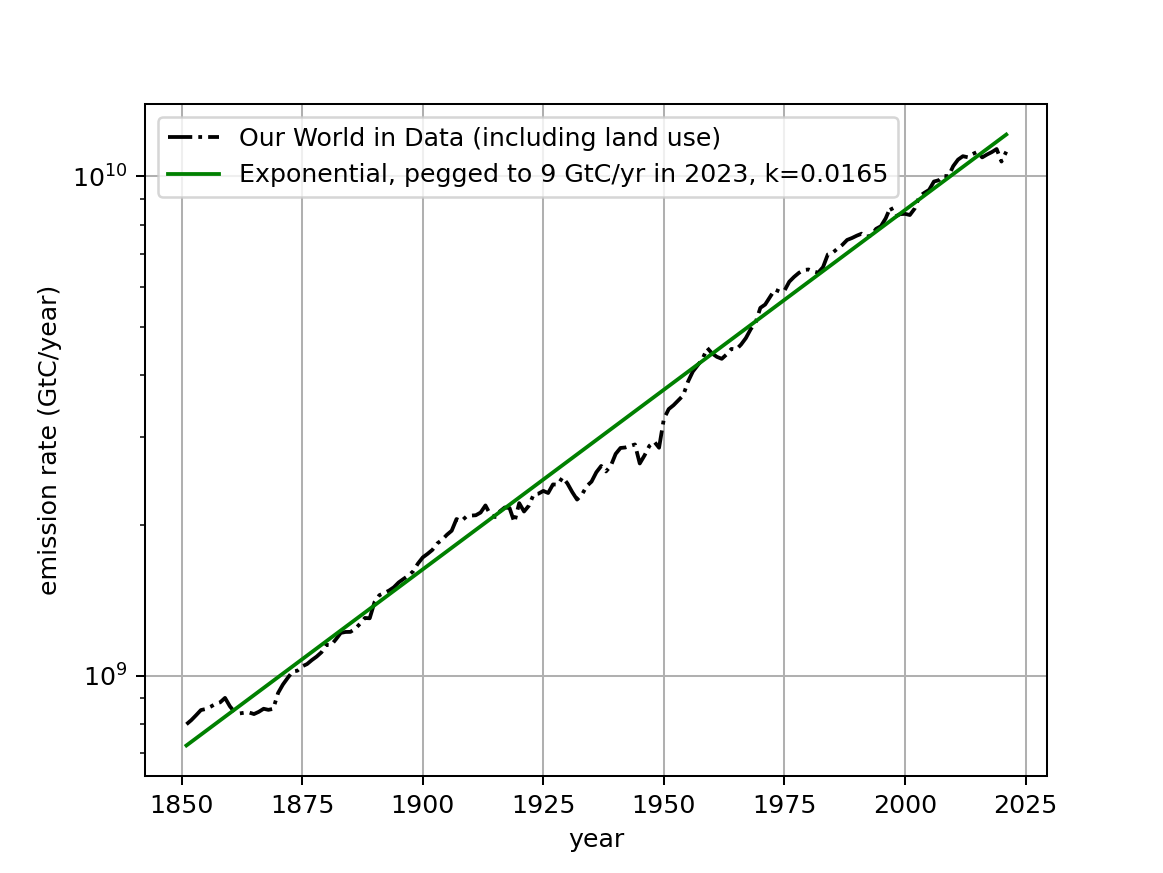

2003.0 9.123212261580381


In [6]:
# Load the data
my_data = genfromtxt('Global emissions with land use.csv', delimiter=',')
time = my_data[1:,0]
eps_ourworldindata = my_data[1:,1]/3.67 # Converts GtCO2 to GtC

# Defining a function to use for least-squares fitting (there are easier ways of doing this)
def linfun(x,a,b):
    return a*x+b

# Fitting
logeps_ourworldindata = np.log(eps_ourworldindata)
popt, pcov = curve_fit(linfun, time, logeps_ourworldindata)
k_ourworldindata = popt[0]
print('k based on our world in data =', k_ourworldindata)

# Pegging the theoretical curve (exponential) to emissions in 2003
cambio_t0 = 2003
cambio_eps0 = 9e9
cambio_k = k_ourworldindata
cambio_eps = np.exp(cambio_k*time)/np.exp(cambio_k*cambio_t0)*cambio_eps0

# Taking a look
plt.figure()
plt.semilogy(time,eps_ourworldindata,'k-.',label='Our World in Data (including land use)')
plt.semilogy(time,cambio_eps, 'g', label='Exponential, pegged to 9 GtC/yr in 2023, k='+str(cambio_k)[0:6])
plt.grid(True)
plt.xlabel('year')
plt.ylabel('emission rate (GtC/year)')
plt.legend()

# Checking the observed emission in the pegged year
i2003 = 152
print(time[i2003],eps_ourworldindata[i2003]/1e9)

# Going forward we might call this "k" 
k = k_ourworldindata

### Using NASA's ratio of net ocean sequestration to net land sequestration to find $k_{oa}$
The ratio of net carbon flux to the ocean vs to land is defined by

$$
r = {\Delta F_{ao} \over \Delta F_{al}} \ \ \ (A1)
$$

where $\Delta F_{ao} = F_{atm->ocean}-F_{ocean->atm}$ and $\Delta F_{al} = F_{atm->land}-F_{land->atm}$. This can be approximated as 

$$
r \approx {k k_{ao} \over k_{al1}(k+k_{oa})} \ \ \ (A2)
$$

How? Our equations of motion say that 

$$
\Delta F_{ao} = {dC_{ocean} \over dt} = k_{ao}C_{atm} - k_{oa}C_{ocean} \ \ \ (A3)
$$

Our "empirical result" (see code below) says 

$$
{d \ ln(\Delta C_{ocean}) \over dt} = {1 \over \Delta C_{ocean}} {d\Delta C_{ocean} \over dt} \approx k \ \ \ (A4)
$$

where $\Delta C_{ocean} = C_{ocean}-C_{ocean}^o$. But ${d\Delta C_{ocean} \over dt}={dC_{ocean} \over dt}$, so 

$$
\Delta F_{ao} = k \Delta C_{ocean} \ \ \ (A5)
$$

Combining A3 and A5 yields

$$
C_{ocean} = {1 \over k+k_{oa}}\bigl( kC_{ocean}^o+k_{ao}C_{atm} \bigr ) \ \ \ (A6)
$$

which means we can write the numerator of Eq. A1 as 

$$
\Delta F_{ao} = k\bigl({1 \over k+k_{oa}} (k C_{ocean}^o+k_{ao}C_{atm})-C_{ocean}^o\bigr) \ \ \ (A7)
$$

Our equations of motion for atmosphere-land exchange say that the denominator of Eq. A1 is given by

$$
\Delta F_{al} = k_{al0}+k_{al1}C_{atm}-k_{la} \ \ \ (A8)
$$

This means we can express A1 as 

$$
r = {k\bigl({1 \over k+k_{oa}} (k C_{ocean}^o+k_{ao}C_{atm})-C_{ocean}^o\bigr) \over k_{al0}+k_{al1}C_{atm}-k_{la}} \ \ \ (A9)
$$

Now we want to take the limit of big $C_{atm}$. To do that, we divide top and bottom of Eq. A9 by $C_{atm}$, and take that limit, giving the desired relationship (Eq. A2). In fact, we'll want to invert that relationship, to 

$$
k_{oa} = k \bigl ( { k_{ao} \over r k_{al1}} -1 \bigr ) \ \ \ (A10)
$$

For example, in the cell below, use of $r=2/3$ (from the NASA figure for the year 2003) yields $k_{oa}=0.16 \ yr^{-1}$. 

In [7]:
# NASA's observed ratio of net ocean sequestration to net land sequestration
r = 2/3 

# Ocean-to-atmosphere flux constant based on Cambio1.0 equations, constrained
# to satisfy the ratio r
print('For Eq. 3:') 
k_oa = k*(k_ao/(r*k_al1)-1)
print('k_oa =', k_oa,'yr^-1')
print('')
print('Related quantities:')
print('t_oa =',1/k_oa,'yr')

For Eq. 3:
k_oa = 0.15975266754338177 yr^-1

Related quantities:
t_oa = 6.259676382107636 yr


As a check on the foregoing, we can also calculate $r$ from the results of a numerical solution. That is done at the bottom of this notebook, with the following results (expecting $r=0.67$): 
- Cambio1.0 yields $r_{numerical}=0.68$
- Cambio2.0 yields $r_{numerical}=0.60$
- Cambio3.0 yields $r_{numerical}=0.60$
- Cambio4.0 yields $r_{numerical}=0.60$

### Finding the pre-industrial ocean carbon reservoir
Here we use the above constants to calculate what the ocean carbon reservoir must have been in order to have been in steady-state in pre-industrial times.

In [8]:
# Atmosphere-to-ocean flux, pre-industrial, according to k_oa just obtained
F_ao_preind = k_ao * C_atm_preind
print('F_ao_preind =', F_ao_preind)

# Ocean-to-atmosphere flux assuming preindustrial steady state
F_oa_preind = F_ao_preind
print('F_oa_preind =', F_oa_preind)

# Net fluxes
print('F_oa_net (preind) =', F_oa_preind-F_ao_preind)

# Implied pre-industrial ocean carbon reservoir
C_ocean_preind = F_oa_preind/k_oa
print('C_ocean_preind =',C_ocean_preind)

print('')
print('Related quantities and checks:')

C_ocean_2003_est = C_atm_2003*k_ao/k_oa
print('C_ocean_2003 (estimated) =',C_ocean_2003_est)

# Known fluxes and concentrations in 1750
C_atm_1750 = 615
Fao_1750 = k_ao * C_atm_1750; print('Just checking ... atmosphere -> ocean flux in 1750 =', Fao_1750)

# Let's assume equilibration of GCC's ocean mixed layer with the atmosphere  
C_ocean_2003_assumed = 1000
F_oa_2003 = 90
k_oa_2003_check = F_oa_2003/C_ocean_2003_assumed; print('Just checking ... k_oa based on 2003 =', k_oa_2003_check)

# In that case, we can back out what the ocean had back in 1750
F_oa_preind_check = F_ao_preind
C_ocean_preind_check = F_oa_preind_check/k_oa; print('Just checking ... C_ocean_preind =', C_ocean_preind_check)

F_ao_preind = 70.72500000000001
F_oa_preind = 70.72500000000001
F_oa_net (preind) = 0.0
C_ocean_preind = 442.7156121245626

Related quantities and checks:
C_ocean_2003 (estimated) = 575.8902271539025
Just checking ... atmosphere -> ocean flux in 1750 = 70.72500000000001
Just checking ... k_oa based on 2003 = 0.09
Just checking ... C_ocean_preind = 442.7156121245626


## Part 2 - Parameters involved in temperature feedbacks

### Diagnosing temperature anomaly from changes in atmospheric $CO_2$ and albedo
Implementing temperature feedbacks requires an algorithm for computing a temperature anomaly from changes in albedo and atmospheric carbon amount. The algorithm used in all Cambio codes is the bilinear form

$$
T_{anomaly} = CS\times\Delta C_{atm}+AS\times\Delta \alpha \ \ \ (B1)
$$

where $\Delta C_{atm}=C_{atm}-C_{atm,preind}$, $\Delta \alpha = \alpha-\alpha_{preind}$, and $\alpha_{preind}=0.3$. $CS$ in this equation is the climate sensitivity parameter (degrees warming per GtC increase in atmospheric $CO_2$), and $AS$ is the albedo sensitivity parameter (degrees warming per unit increase in albedo). $CS$ is obtained using the assumption 3 degrees warming for a doubling of atmospheric $CO_2$, which corresponds to $CS={3 \over 615} = 0.0049 {^\circ C \over GtC}$. $AS$ is determined from a simple radiative balance model, which equates incoming shortwave radiance ($\dfrac{S_0}{4}(1-\alpha)$) to outgoing longwave radiance ($\kappa \sigma T^4$, with $\kappa=0.614$), yielding $AS=-102.8 ^\circ C$. (See the cell below).

287.91466299374713 14.914662993747129
-102.82666535490968
0.004878048780487805


<IPython.core.display.Javascript object>


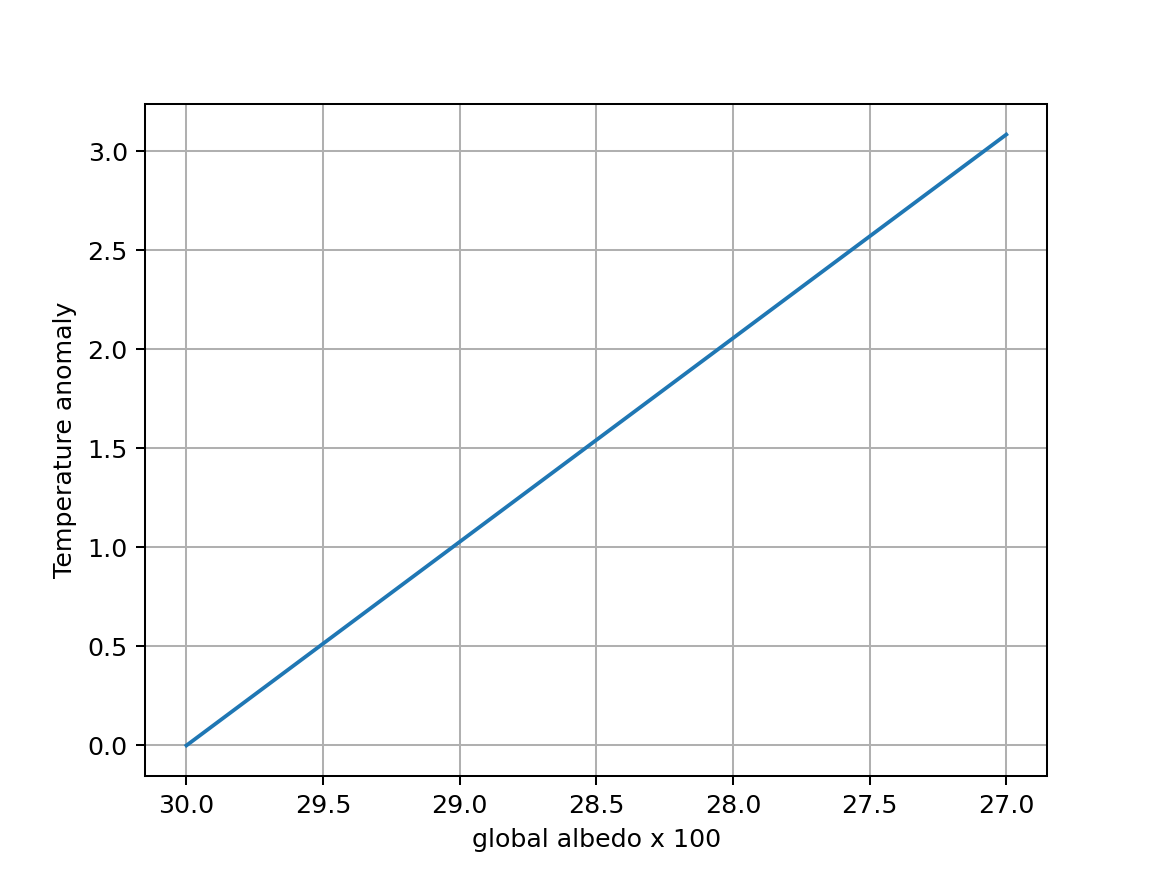

In [9]:
# Albedo sensitivity
alpha0 = 0.3
S0 = 1367
kappa = 0.614
sigma = 5.67e-8
Teq = (S0/4*(1-alpha0)/(kappa*sigma))**.25; print(Teq,Teq-273)
AS = -1/4*(S0/4*(1-alpha0)/(kappa*sigma))**(.25-1)*S0/4/(kappa*sigma); print(AS)

# Climate (carbon) sensitivity
CS = 3/615; print(CS)

# Let's take a look
Delta_albedo = np.linspace(0,alpha0*0.9-alpha0)
albedo = alpha0+Delta_albedo
T_anomaly_from_formula = AS*Delta_albedo
plt.figure()
plt.plot(albedo*100,T_anomaly_from_formula)
plt.grid(True)
plt.xlabel('global albedo x 100')
plt.ylabel('Temperature anomaly')
plt.gca().invert_xaxis()

### Finding $DC$, which determines the T-dependence of ocean-to-atmosphere $CO_2$ discharge, using Henry's Law
Going back to Eq. 3, recall that $DC$ was assumed to be zero in Cambio1.0, meaning there is no accounting for a temperature dependence of the outgassing of carbon in the ocean to the atmosphere. Cambio2.0 implements this outgassing via a linear dependence of Henry's constant on temperature,

$$
H = H_o + DC' \times \Delta T \ \ \ (C1)
$$

where $H_o = H$ at some reference temperature. If we say the reference temperature is the pre-industrial global mean temperature, $T_o=15°C$, then according to https://demonstrations.wolfram.com/TemperatureDependenceOfHenrysLawConstant/, $H_o=1220$ and $DC'=38.46$ (tangent to $H(T)$ at $T_o$).

For our problem, equilibrium at $T_o$ means equal fluxes, so 

$$
{C_{atm} \over C_{ocean}} = {k_{oa} \over k_{ao}} \propto H_o + DC' \times \Delta T \ \ \ (C2)
$$

We'll let $k_{oa}$ represent this temperature dependence:

$$
k_{oa} = k_{oa}^o \times (1 + DC \times \Delta T) = k_{oa}^o \times {1 \over H_o} \times (H_o + DC' \times \Delta T) \ \ \ (C3)
$$

As the code below shows, this leads to $DC = {DC' \over H_o}=0.032 \ K^{-1}$.

In [10]:
# Relative change in Henry's constant for CO2 
DCprime = (2200-1220)/(40-15); print(DCprime)
H0 = 1220
DC = DCprime/H0; print(DC)

39.2
0.03213114754098361


### Parameterizing a generic $\sigma_{floor}$
Going back to Eq. 2, recall that we deferred discussing parameterization of the sigmoid function in that expression, because this only comes into play in Cambio4.0. Before entering that context, however, we will develop generic properties of sigmoid functions. $\sigma_{floor}$ has three parameters:

1. $x_{trans}$, the sigmoid's transition or threshold value, where the sigmoid is half-way from its starting value to its ending value;  
1. $x_{interval}$, the interval of $x$ over which approximately $90\%$ of the transition to the the half-way point takes place; and 
1. $\sigma_{floor,\infty}$, the final value of the sigmoid function (the initial value is 1).

Some generic examples are displayed in a code cell below. 

<IPython.core.display.Javascript object>


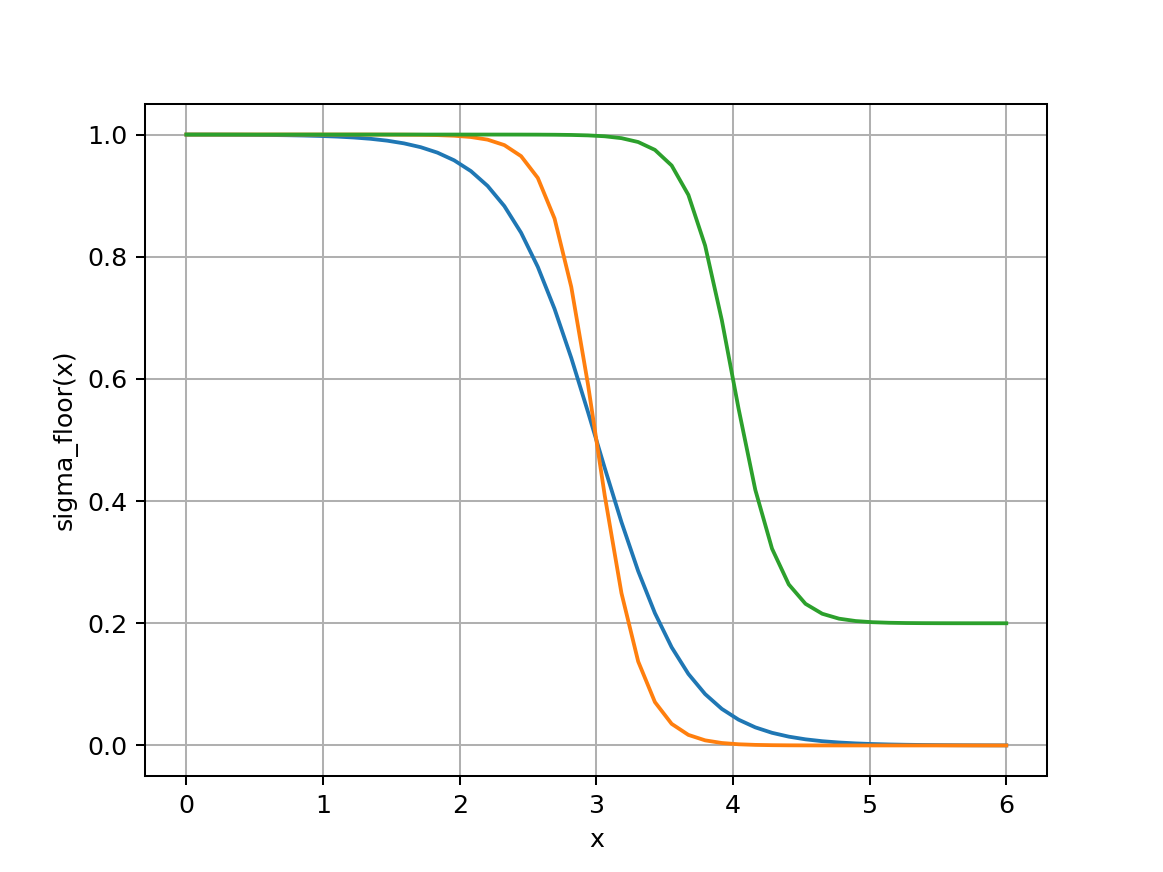

Text(0, 0.5, 'sigma_floor(x)')

In [11]:
x = np.linspace(0,6)
plt.figure()
plt.plot(x,CL.sigmafloor(x,x_trans=3,x_interval=1,sigma_floor_infinity=0))
plt.plot(x,CL.sigmafloor(x,x_trans=3,x_interval=0.5,sigma_floor_infinity=0))
plt.plot(x,CL.sigmafloor(x,x_trans=4,x_interval=0.5,sigma_floor_infinity=0.2))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('sigma_floor(x)')

### Representing loss of Arctic ice with a sigmoid function of the temperature anomaly
Wunderly et al, 2020 (https://www.nature.com/articles/s41467-020-18934-3) estimate the global temperature impact of a transition to a climate state in which summertime Arctic ice and alpine glaciers are lost, in addition to a limited decline of WAIS and Greenland ice. resulting in an additional global warming of $+0.43 K$. 

We represent this transition in Cambio3.0 as a sigmoidal albedo effect, as follows: First, we figure out the  change in the global albedo that would produce that warming, 

$$
\Delta \alpha_{ASI} = {0.43 \over -103} = -0.004 \ \ \ (C1)
$$

We then specify the impact of temperature anomaly on global albedo as a sigmoid function,

$$
\alpha = \alpha_{preind} \times \sigma_{floor,ice-albedo}(T_{anomaly}) \ \ \ (C2)
$$

where $\alpha_{preind}=0.3$ and the "floor" parameter of $\sigma_{floor,ice-albedo}$ is given by

$$
\sigma_{floor,\infty,T_{anomaly}} = 1 + \Delta \alpha_{ASI}/\alpha_{preind} = 0.986 \ \ \ (C3)
$$

The other two parameters of $\sigma_{floor,ice-albedo}$ specify the temperature anomaly at which this transition is half-way complete ($T_{anomaly,\alpha, trans}=2 ^oC$), and the abruptness of that transition ($T_{anomaly,\alpha, interval}=0.5 ^oC$). 

This representation can be summed up as follows: as long as $T_{anomaly}<1.5 ^oC$, global albedo will remain close to its pre-industrial value of $\alpha_{preind}=0.3$, but once $T_{anomaly}>2.5 ^oC$, global albedo will fall to $\alpha=0.3-0.004=0.296$.

Predicted global albedo change after loss of Arctic ice = -0.004181794659156169
fractional floor = 0.9860606844694794
global albedo after loss of ice 0.2958182310345204
global albedo change after loss of ice -0.004181743271803096


<IPython.core.display.Javascript object>


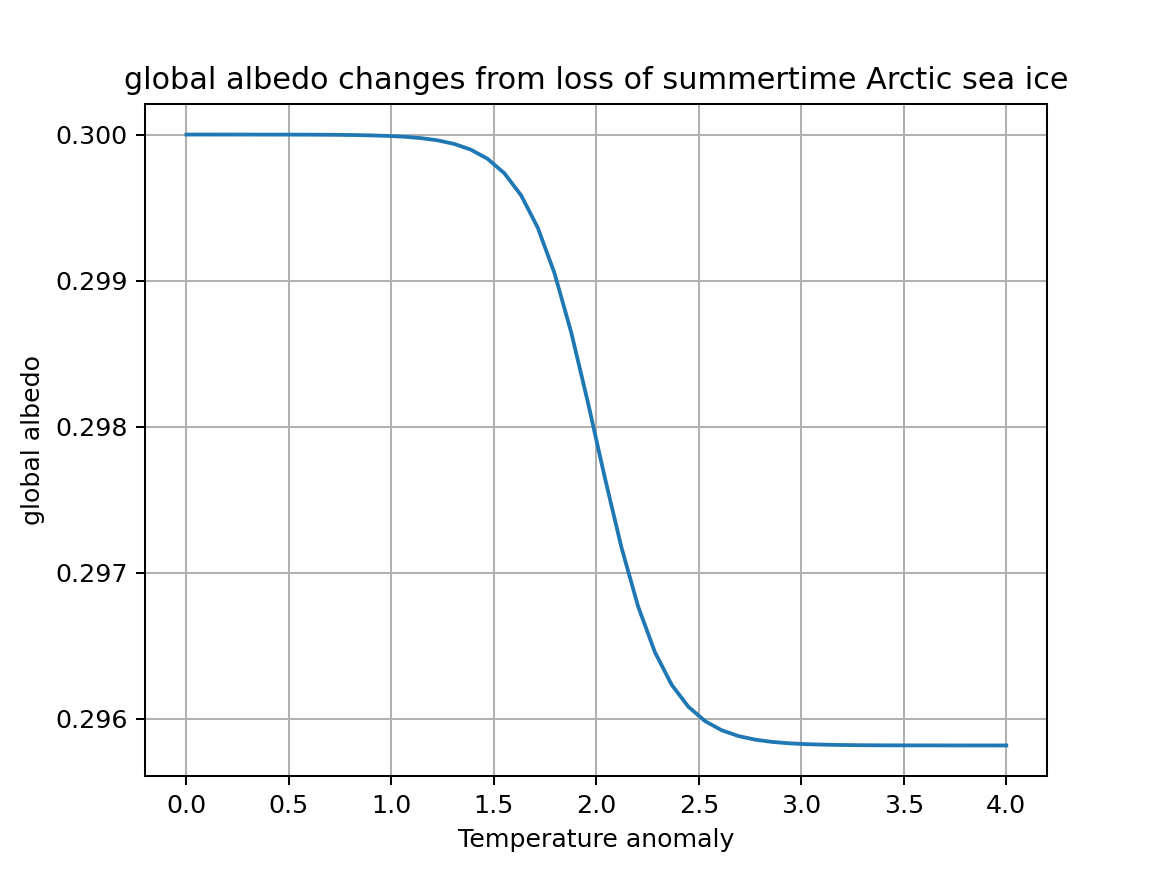

Text(0.5, 1.0, 'global albedo changes from loss of summertime Arctic sea ice')

In [12]:
T_anomaly_ASI = 0.43
Delta_alpha_ASI = T_anomaly_ASI/AS
print('Predicted global albedo change after loss of Arctic ice =', Delta_alpha_ASI)
albedo_Tstar = 2
T_anomaly = np.linspace(0,2*albedo_Tstar)
albedo_deltaT = 0.5
preindustrial_albedo = 0.3
fractional_albedo_floor = (preindustrial_albedo+Delta_alpha_ASI)/preindustrial_albedo
print('fractional floor =', fractional_albedo_floor)
albedo = preindustrial_albedo*CL.sigmafloor(T_anomaly,albedo_Tstar,albedo_deltaT,fractional_albedo_floor)
print('global albedo after loss of ice', albedo[-1])
print('global albedo change after loss of ice', albedo[-1]-albedo[0])
plt.figure()
plt.plot(T_anomaly,albedo)
plt.grid(True)
plt.xlabel('Temperature anomaly')
plt.ylabel('global albedo')
plt.title('global albedo changes from loss of summertime Arctic sea ice')

### Parameterization of the temperature dependence of $CO_2$ fertilization
The cells below are meant to adjust parameters controlling the temperature dependence of $CO_2$ fertilization. We'll start with two functions that reproduce Cambio4, but return specialized information used in the fitting.

In [13]:
def get_net_fluxes_Cambio4(ClimateParams,epstime,eps):
    
    # Make the starting state the preindustrial
    ClimateState = CL.CreateClimateState(ClimateParams)

    # Initialize our list of climate states 
    ClimateState_list = []

    # The time interval
    dt = epstime[1]-epstime[0]

    # Loop over all the times after the initial one in the scheduled flow
    for i in range(1,len(epstime)):

        # Propagate
        ClimateState = CL.PropagateClimateState_Cambio4(ClimateState, ClimateParams, dt, eps[i])

        # Add to our list of climate states
        ClimateState_list.append(ClimateState)

    # Extracting data from ClimateState_list
    time_array = CL.CollectClimateTimeSeries(ClimateState_list,'time')
    F_al_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_al')
    F_la_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_la')

    # Compute the net fluxes
    F_land_net = F_la_array-F_al_array
    
    # Return
    return time_array, F_land_net

def funcCambio4(x,k_al1_Tstar,k_al1_deltaT,fractional_k_al1_floor):
    ClimateParams_test = makeacopy(ClimateParams)
    ClimateParams_test['k_al1_Tstar'] = k_al1_Tstar
    ClimateParams_test['k_al1_deltaT'] = k_al1_deltaT
    ClimateParams_test['fractional_k_al1_floor'] = fractional_k_al1_floor
    time_array, F_land_net = get_net_fluxes_Cambio4(ClimateParams_test,epstime,eps)
    F_land_net_selected = F_land_net[itimes]
    return F_land_net_selected

### We'll need an emissions scenario for this.

<IPython.core.display.Javascript object>


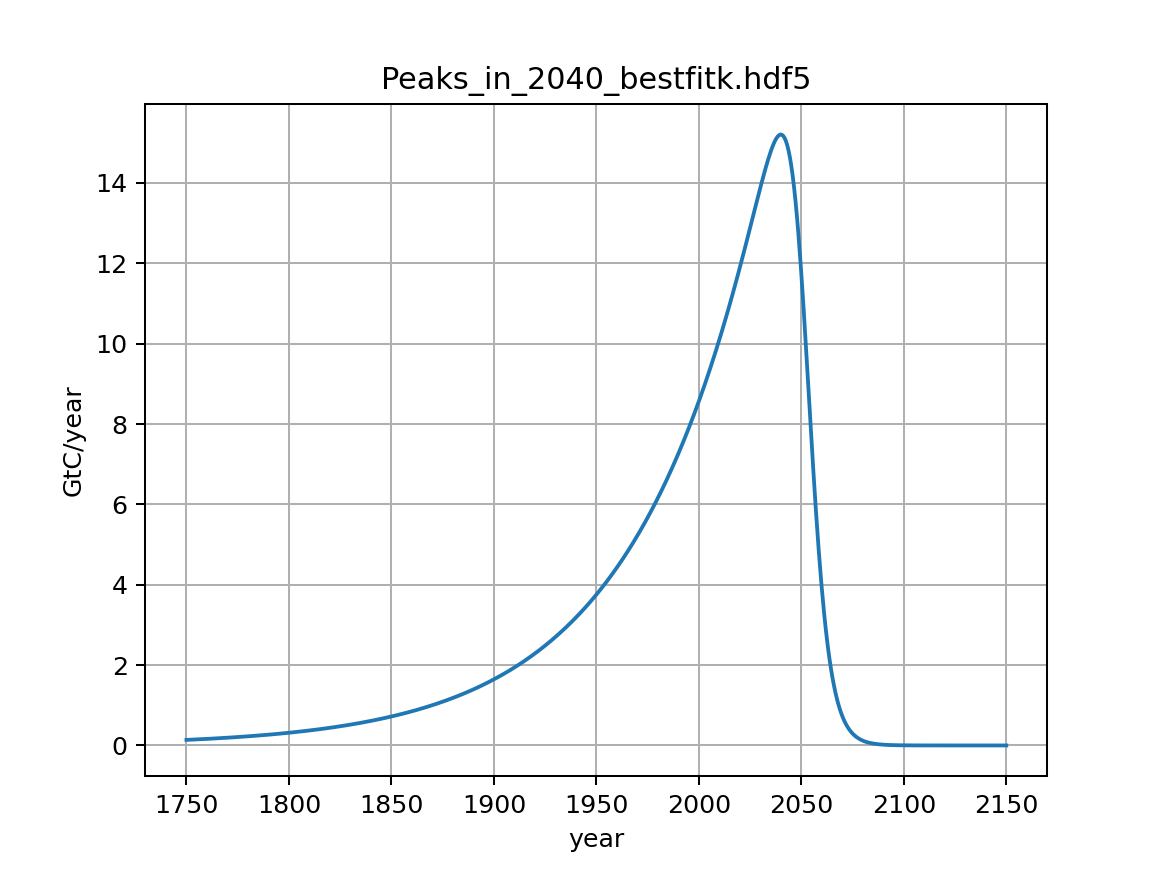

{'dataframe':             time     emissions
 0    1750.000000  1.384459e-01
 1    1750.667780  1.399798e-01
 2    1751.335559  1.415307e-01
 3    1752.003339  1.430987e-01
 4    1752.671119  1.446842e-01
 ..           ...           ...
 595  2147.328881  5.154266e-07
 596  2147.996661  4.559838e-07
 597  2148.664441  4.033964e-07
 598  2149.332220  3.568738e-07
 599  2150.000000  3.157165e-07
 
 [600 rows x 2 columns],
 'emission units': 'GtC/year',
 'eps_0': 9,
 'k': 0.0165,
 't_0': 2003,
 't_decarb': 15,
 't_peak': 2040}

{'k_la': 120,
 'k_al0': 110.02702702702703,
 'k_al1': 0.016216216216216217,
 'k_oa': 0.15901875,
 'k_ao': 0.115,
 'k': 0.0165,
 'DC': 0.032,
 'climate sensitivity': 0.004878048780487805,
 'preindustrial C_atm': 615,
 'albedo sensitivity': -102.8,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': 1750.0,
 'k_al1_Tstar': 1.35,
 'k_al1_deltaT': 0.44,
 'fractional_k_al1_floor': 0.7,
 'albedo_Tstar': 2,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 0.9860570687418937}

In [14]:
# Here's loading in a scenario, with graphics
epstime, eps, epsdictionary = CL.GetMyScenario('Peaks_in_2040_bestfitk.hdf5')

# Here's displaying it
display(epsdictionary)

# Getting parameters that depend (in part) on that scenario
ClimateParams = CL.CreateClimateParams(epsdictionary)
display(ClimateParams)

### Next we'll get desired net fluxes that try to incorporate Ke et al's results.

In [15]:
# Get a fresh copy of climate parameters
ClimateParams = CL.CreateClimateParams(epsdictionary)
print('What CL.CreateClimateParams creates, unmodified:')
display(ClimateParams)

# Modify some parameters as initial values for the optimization
ClimateParams['k_al1_Tstar'] = 2
ClimateParams['k_al1_deltaT'] = .5
ClimateParams['fractional_k_al1_floor'] = 1 # Setting this equal to 1 disables any modification to k_al1 

# This puts the tipping point for albedo way out of range, so albedo won't affect our optimization
# If these two lines of code are omitted, the resulting optimized parameters 
# k_al1_Tstar, k_al1_deltaT, and fractional_k_al1_floor don't change much (which is good)
ClimateParams['albedo_Tstar'] = 10
ClimateParams['fractional_albedo_floor'] = 1 # "pants = suspenders" 

# See what we have
print('What CL.CreateClimateParams creates, modified for fitting:')
display(ClimateParams)

# Record the fluxes
time_array, F_land_net = get_net_fluxes_Cambio4(ClimateParams,epstime,eps)

# The following blocs of code select out fluxes (modified according to Ke et al) 
# to be used in the optimization

# Select out some times to focus on fluxes, pre
F_land_net_selected_observed = np.empty(0)
times_pre = np.arange(1950,1985)
itimes_pre = []
for i in range(len(times_pre)):
    itime = np.argmin((time_array-times_pre[i])**2)
    itimes_pre.append(itime)
    F_land_net_selected_observed = np.append(F_land_net_selected_observed,F_land_net[itime])
F_land_net_selected_observed = F_land_net[itimes_pre]

# Select out some times to focus on fluxes, post
times_post = np.arange(2017,2024)
fluxes_post = -np.array([2.4, 1.8, 1.5, 1.3, 1.8, 3.1, 0.44])
itimes_post = []
for i in range(len(times_post)):
    itime = np.argmin((time_array-times_post[i])**2)
    itimes_post.append(itime)
    F_land_net_selected_observed = np.append(F_land_net_selected_observed,fluxes_post[i])

# Concatenate the times
itimes = itimes_pre+itimes_post

What CL.CreateClimateParams creates, unmodified:


{'k_la': 120,
 'k_al0': 110.02702702702703,
 'k_al1': 0.016216216216216217,
 'k_oa': 0.15901875,
 'k_ao': 0.115,
 'k': 0.0165,
 'DC': 0.032,
 'climate sensitivity': 0.004878048780487805,
 'preindustrial C_atm': 615,
 'albedo sensitivity': -102.8,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': 1750.0,
 'k_al1_Tstar': 1.35,
 'k_al1_deltaT': 0.44,
 'fractional_k_al1_floor': 0.7,
 'albedo_Tstar': 2,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 0.9860570687418937}

What CL.CreateClimateParams creates, modified for fitting:


{'k_la': 120,
 'k_al0': 110.02702702702703,
 'k_al1': 0.016216216216216217,
 'k_oa': 0.15901875,
 'k_ao': 0.115,
 'k': 0.0165,
 'DC': 0.032,
 'climate sensitivity': 0.004878048780487805,
 'preindustrial C_atm': 615,
 'albedo sensitivity': -102.8,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': 1750.0,
 'k_al1_Tstar': 2,
 'k_al1_deltaT': 0.5,
 'fractional_k_al1_floor': 1,
 'albedo_Tstar': 10,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 1}

### Optimization of parameters related to $CO_2$ fertilization
Next we optimize parameters related to $CO_2$ fertilization. funcCambio4 picks up ClimateParams as a global variable rather than having that information come in through an argument list, because I wasn't sure how to do the latter, and this works.

In [16]:
x = []
k_al1_Tstar = ClimateParams['k_al1_Tstar']
k_al1_deltaT = ClimateParams['k_al1_deltaT']
fractional_k_al1_floor = ClimateParams['fractional_k_al1_floor']

# Optimize parameters related to CO2 fertilization
k_al1_Tstar_opt,k_al1_deltaT_opt,fractional_k_al1_floor_opt = \
    optimize.curve_fit(funcCambio4, xdata = x, ydata = F_land_net_selected_observed)[0]
print('parameters k_al1_Tstar, k_al1_deltaT, and fractional_k_al1_floor')
print('starting:  ', k_al1_Tstar,k_al1_deltaT,fractional_k_al1_floor)
print('optimized: ', k_al1_Tstar_opt,k_al1_deltaT_opt,fractional_k_al1_floor_opt)

parameters k_al1_Tstar, k_al1_deltaT, and fractional_k_al1_floor
starting:   2 0.5 1
optimized:  1.3469864072199633 0.4415547433552562 0.6970145635025827


### Verifying the current version of CL.CreateClimateParams
ClimateParams as currently returned should have k_al1_Tstar, k_al1_deltaT, and fractional_k_al1_floor values close to the optimized ones just quoted.

In [17]:
print('ClimateParams used for optimization (w/k_al1_Tstar, k_al1_deltaT, and fractional_k_al1_floor adjustable):')
display(ClimateParams)

print('ClimateParams as currently returned:')
display(CL.CreateClimateParams(epsdictionary))

ClimateParams used for optimization (w/k_al1_Tstar, k_al1_deltaT, and fractional_k_al1_floor adjustable):


{'k_la': 120,
 'k_al0': 110.02702702702703,
 'k_al1': 0.016216216216216217,
 'k_oa': 0.15901875,
 'k_ao': 0.115,
 'k': 0.0165,
 'DC': 0.032,
 'climate sensitivity': 0.004878048780487805,
 'preindustrial C_atm': 615,
 'albedo sensitivity': -102.8,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': 1750.0,
 'k_al1_Tstar': 2,
 'k_al1_deltaT': 0.5,
 'fractional_k_al1_floor': 1,
 'albedo_Tstar': 10,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 1}

ClimateParams as currently returned:


{'k_la': 120,
 'k_al0': 110.02702702702703,
 'k_al1': 0.016216216216216217,
 'k_oa': 0.15901875,
 'k_ao': 0.115,
 'k': 0.0165,
 'DC': 0.032,
 'climate sensitivity': 0.004878048780487805,
 'preindustrial C_atm': 615,
 'albedo sensitivity': -102.8,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': 1750.0,
 'k_al1_Tstar': 1.35,
 'k_al1_deltaT': 0.44,
 'fractional_k_al1_floor': 0.7,
 'albedo_Tstar': 2,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 0.9860570687418937}

### Plotting the terrestrial atmosphere-to-land flux 
The cell below plots terrestrial atmosphere-to-land flux as a function of the carbon in the air, with and without terrestrial sequestration feedback as we just parameterized it. We're not deriving any new parameters here, just looking at the effect. 

<IPython.core.display.Javascript object>


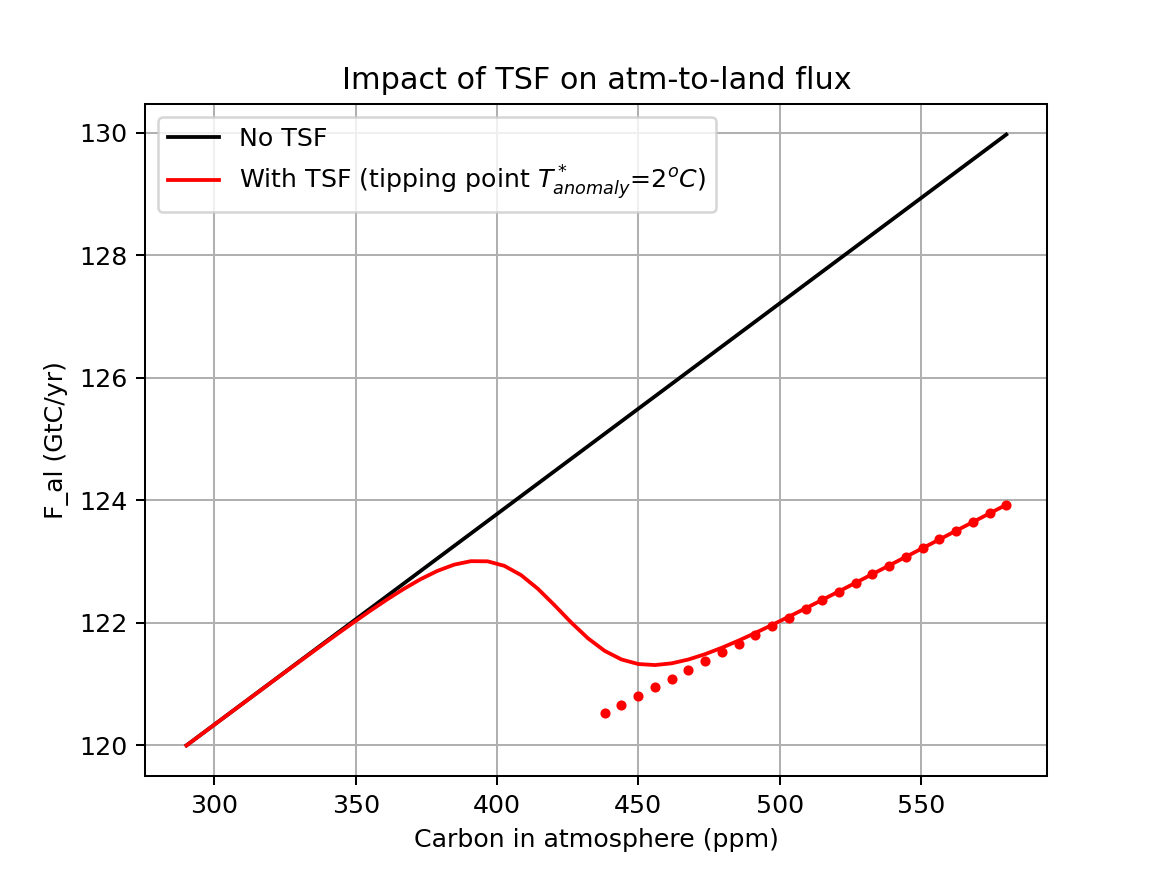

<IPython.core.display.Javascript object>


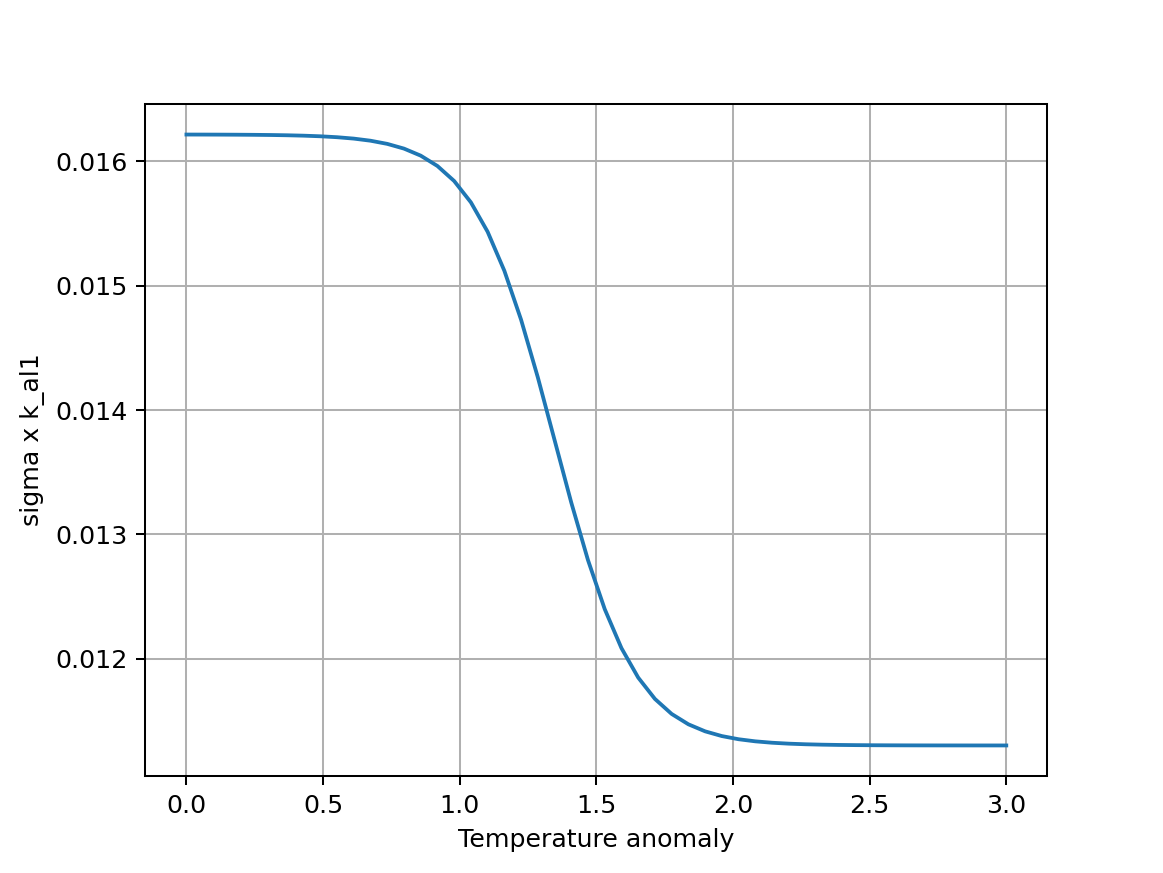

In [18]:
# A range of atmospheric CO2 amounts (preindustrial to 2x that)
C_atm_array = np.linspace(615,2*615)
C_atm_array_ppm = C_atm_array/2.12

# Get the temperature anomaly that would result from that, assuming no ice-albedo feedback
T_anomaly = CL.Diagnose_T_anomaly(C_atm_array, 0.3, ClimateParams)

# Other parameters we'll need for this comparison 
k_al0 = ClimateParams['k_al0']
k_al1 = ClimateParams['k_al1']

# Terrestrial atmosphere-to-land flux with and without terrestrial sequestration feedback
F_al_without_tsf = k_al0 + k_al1*C_atm_array
F_al_with_tsf_extrap = k_al0 + k_al1*C_atm_array*fractional_k_al1_floor_opt
F_al_with_tsf = k_al0 + k_al1*C_atm_array*\
            CL.sigmafloor(T_anomaly,k_al1_Tstar_opt,k_al1_deltaT_opt,fractional_k_al1_floor_opt)

# Plot them side by side
iextrap = int(len(C_atm_array_ppm)/2)
plt.figure()
plt.plot(C_atm_array_ppm,F_al_without_tsf,'k',label="No TSF")
plt.plot(C_atm_array_ppm,F_al_with_tsf,'r',label="With TSF (tipping point $T^*_{anomaly}$="+str(k_al1_Tstar)+"$^oC$)")
plt.plot(C_atm_array_ppm[iextrap:],F_al_with_tsf_extrap[iextrap:],'r.')
plt.xlabel('Carbon in atmosphere (ppm)')
plt.ylabel('F_al (GtC/yr)')
plt.title('Impact of TSF on atm-to-land flux')
plt.legend()
plt.grid()

# Plotting the sigmoid function times the CO2 fertilization term to show what that looks like
sigma_test = CL.sigmafloor(T_anomaly,k_al1_Tstar_opt,k_al1_deltaT_opt,fractional_k_al1_floor_opt)
plt.figure()
plt.plot(T_anomaly,sigma_test*ClimateParams['k_al1'])
plt.xlabel('Temperature anomaly')
plt.ylabel('sigma x k_al1')
plt.grid(True)

### Running a simulation with Wunderland-informed $CO_2$ fertilization reductions
The code below creates a new ClimateParams dictionary (ClimateParams_test) that has the albedo sensitivity removed (as was used in the optimization just carried out). Then it runs a Cambio4 simulation.

ClimateParams used for this simulation:


{'k_la': 120,
 'k_al0': 110.02702702702703,
 'k_al1': 0.016216216216216217,
 'k_oa': 0.15901875,
 'k_ao': 0.115,
 'k': 0.0165,
 'DC': 0.032,
 'climate sensitivity': 0.004878048780487805,
 'preindustrial C_atm': 615,
 'albedo sensitivity': -102.8,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': 1750.0,
 'k_al1_Tstar': 1.3469864072199633,
 'k_al1_deltaT': 0.4415547433552562,
 'fractional_k_al1_floor': 0.6970145635025827,
 'albedo_Tstar': 10,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 1}

<IPython.core.display.Javascript object>


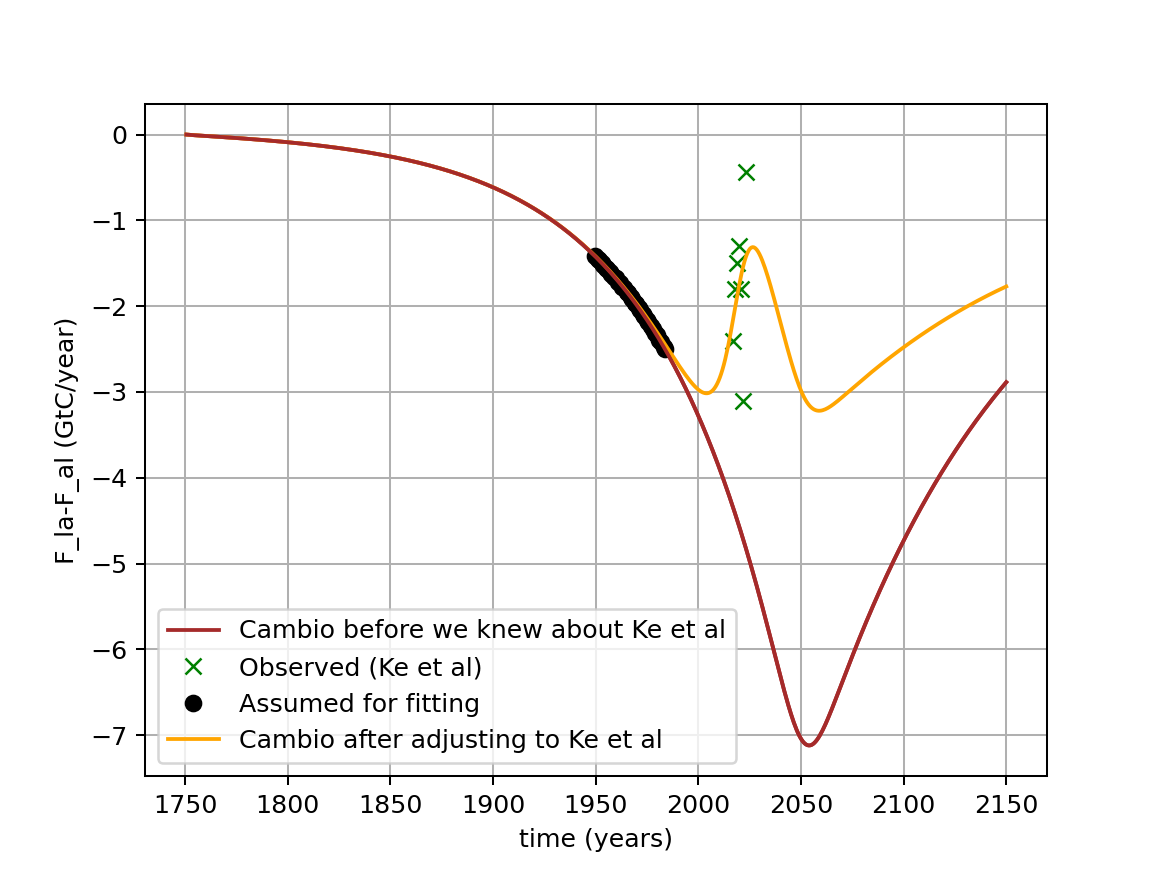

In [19]:
# Copy the ClimateParams dictionary used for optimization (i.e., with albedo sensitivity removed)
ClimateParams_test = makeacopy(ClimateParams)

# Override the CO2 fertilization parameters
ClimateParams_test['k_al1_Tstar'] = k_al1_Tstar_opt
ClimateParams_test['k_al1_deltaT'] = k_al1_deltaT_opt
ClimateParams_test['fractional_k_al1_floor'] = fractional_k_al1_floor_opt

# Reporting
print('ClimateParams used for this simulation:')
display(ClimateParams_test)

# Run a Cambio4 simulation with these modifications and plot the fluxes
time_array, F_land_net_test = get_net_fluxes_Cambio4(ClimateParams_test,epstime,eps)
plt.figure()
plt.plot(time_array,F_land_net,label='Cambio before we knew about Ke et al',color='brown')
plt.plot(times_post,fluxes_post,'x',label='Observed (Ke et al)',color='green')
plt.plot(time_array[itimes_pre],F_land_net[itimes_pre],'o',label='Assumed for fitting',color='k')
plt.plot(time_array,F_land_net_test,label='Cambio after adjusting to Ke et al',color='orange')
plt.xlabel('time (years)')
plt.ylabel("F_la-F_al (GtC/year)")
plt.grid(True)
plt.legend()
plt.plot(time_array,F_land_net,label='Cambio before we knew about Ke et al',color='brown')

### Running a simulation with Wunderland-informed $CO_2$ fertilization reductions and ice-albedo feedback
The code below is similar to what we just did, but uses a version of the new ClimateParams dictionary (ClimateParams_test) that has the default albedo sensitivity included. What we're looking for here is whether that inclusion changes things much; if it doesn't, then optimizing k_al1_Tstar, k_al1_deltaT, and fractional_k_al1_floor without albedo sensitivity (as done in the optimization above) probably wouldn't change things much.

ClimateParams used for this simulation:


{'k_la': 120,
 'k_al0': 110.02702702702703,
 'k_al1': 0.016216216216216217,
 'k_oa': 0.15901875,
 'k_ao': 0.115,
 'k': 0.0165,
 'DC': 0.032,
 'climate sensitivity': 0.004878048780487805,
 'preindustrial C_atm': 615,
 'albedo sensitivity': -102.8,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': 1750.0,
 'k_al1_Tstar': 1.3469864072199633,
 'k_al1_deltaT': 0.4415547433552562,
 'fractional_k_al1_floor': 0.6970145635025827,
 'albedo_Tstar': 2,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 0.9860570687418937}

<IPython.core.display.Javascript object>


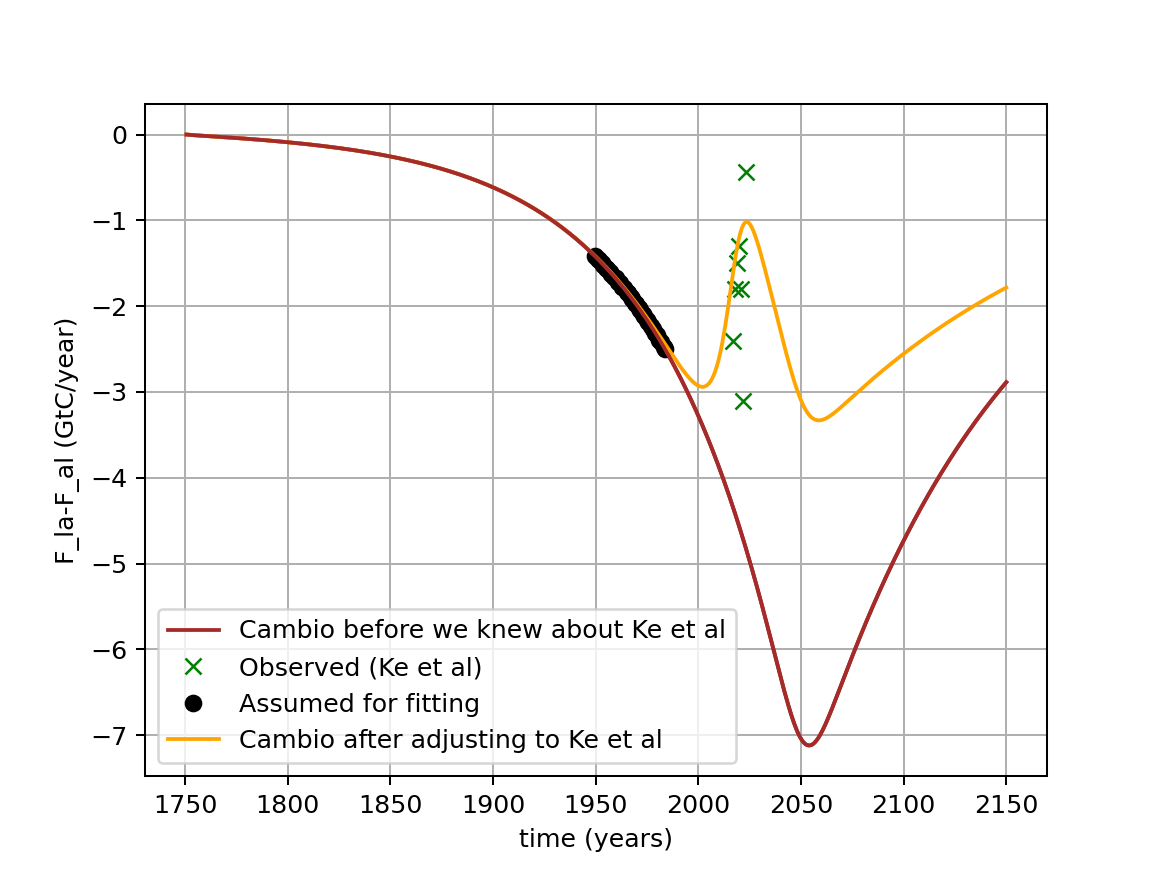

In [20]:
# Copy the default ClimateParams dictionary (so it has whatever the default albedo sensitivity is)
ClimateParams_test = CL.CreateClimateParams(epsdictionary)

# Override the CO2 fertilization parameters
ClimateParams_test['k_al1_Tstar'] = k_al1_Tstar_opt
ClimateParams_test['k_al1_deltaT'] = k_al1_deltaT_opt
ClimateParams_test['fractional_k_al1_floor'] = fractional_k_al1_floor_opt

# Reporting
print('ClimateParams used for this simulation:')
display(ClimateParams_test)

# Run a Cambio4 simulation with these modifications and plot the fluxes
time_array, F_land_net_test = get_net_fluxes_Cambio4(ClimateParams_test,epstime,eps)
plt.figure()
plt.plot(time_array,F_land_net,label='Cambio before we knew about Ke et al',color='brown')
plt.plot(times_post,fluxes_post,'x',label='Observed (Ke et al)',color='green')
plt.plot(time_array[itimes_pre],F_land_net[itimes_pre],'o',label='Assumed for fitting',color='k')
plt.plot(time_array,F_land_net_test,label='Cambio after adjusting to Ke et al',color='orange')
plt.xlabel('time (years)')
plt.ylabel("F_la-F_al (GtC/year)")
plt.grid(True)
plt.legend()
plt.plot(time_array,F_land_net,label='Cambio before we knew about Ke et al',color='brown')

## Analysis-related code below here

### Run a Cambio4 simulation again, for more graphical output

<IPython.core.display.Javascript object>


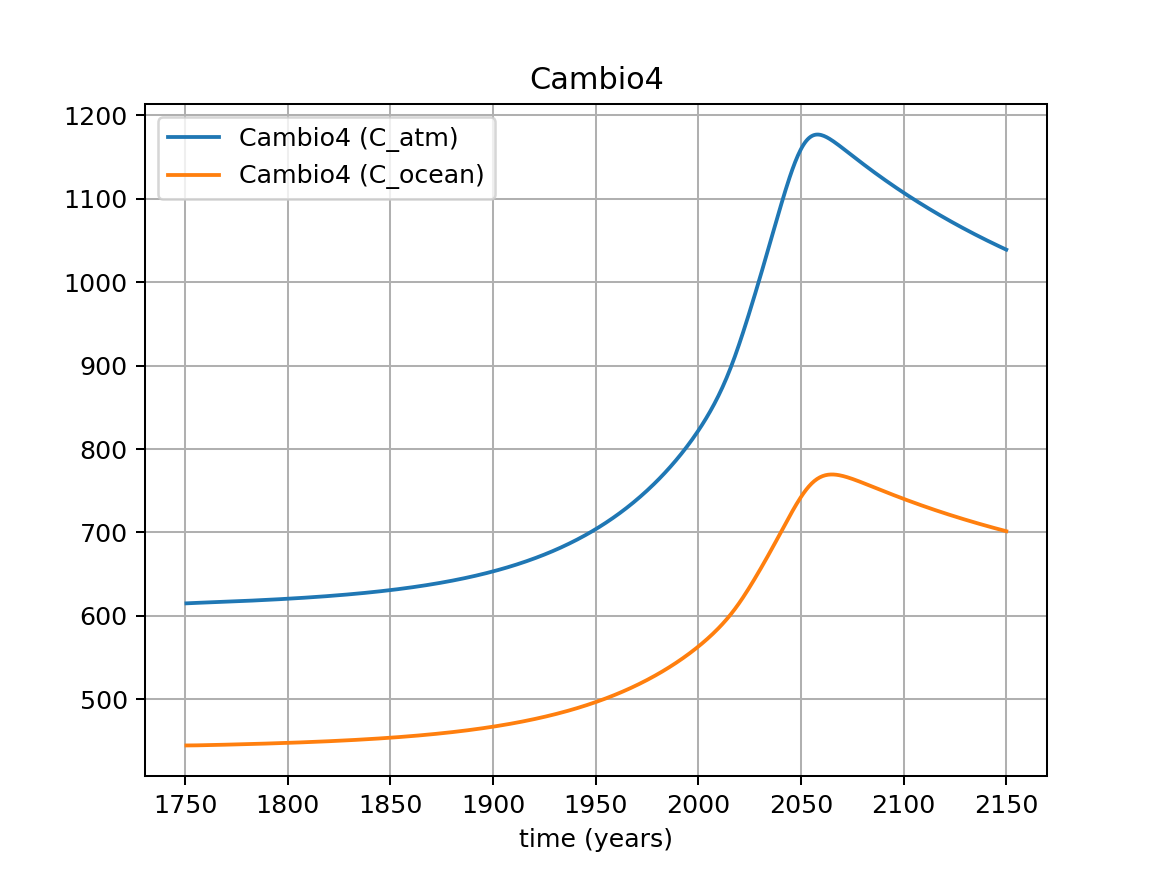

Max of Cambio4 (C_atm) =  1176.9718509359172 at time  2057.846410684496
Min of Cambio4 (C_atm) =  615.0936896208832 at time  1750.6677796327212
Max of Cambio4 (C_ocean) =  769.5519748158908 at time  2065.1919866444296
Min of Cambio4 (C_ocean) =  444.75887277443707 at time  1750.6677796327212


<IPython.core.display.Javascript object>


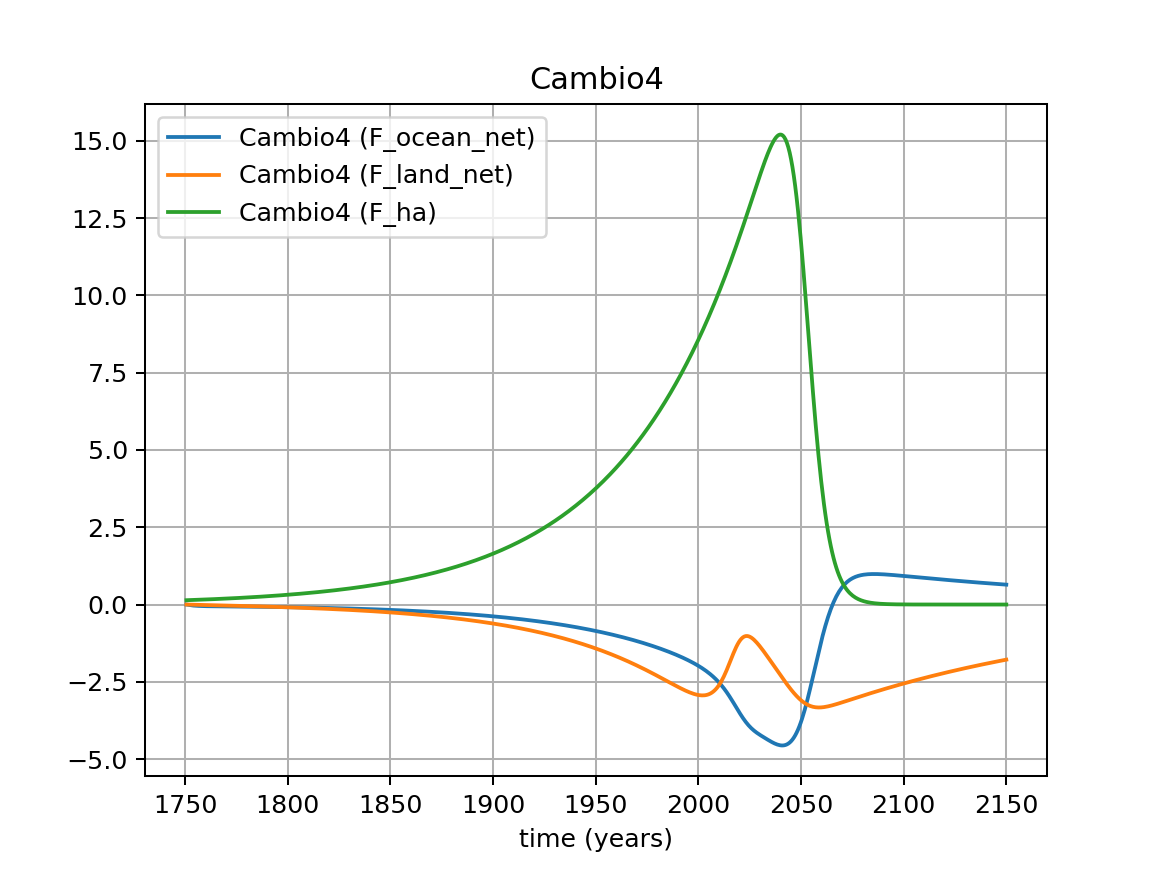

Max of Cambio4 (F_ocean_net) =  0.9868508911910396 at time  2085.8931552587883
Min of Cambio4 (F_ocean_net) =  -4.558863842015697 at time  2041.1519198664646
Max of Cambio4 (F_land_net) =  0.00032039414611517714 at time  1750.6677796327212
Min of Cambio4 (F_land_net) =  -3.330294046572405 at time  2058.514190317217
Max of Cambio4 (F_ha) =  15.2041945039697 at time  2039.816360601022
Min of Cambio4 (F_ha) =  3.157165122377946e-07 at time  2150.000000000028


<IPython.core.display.Javascript object>


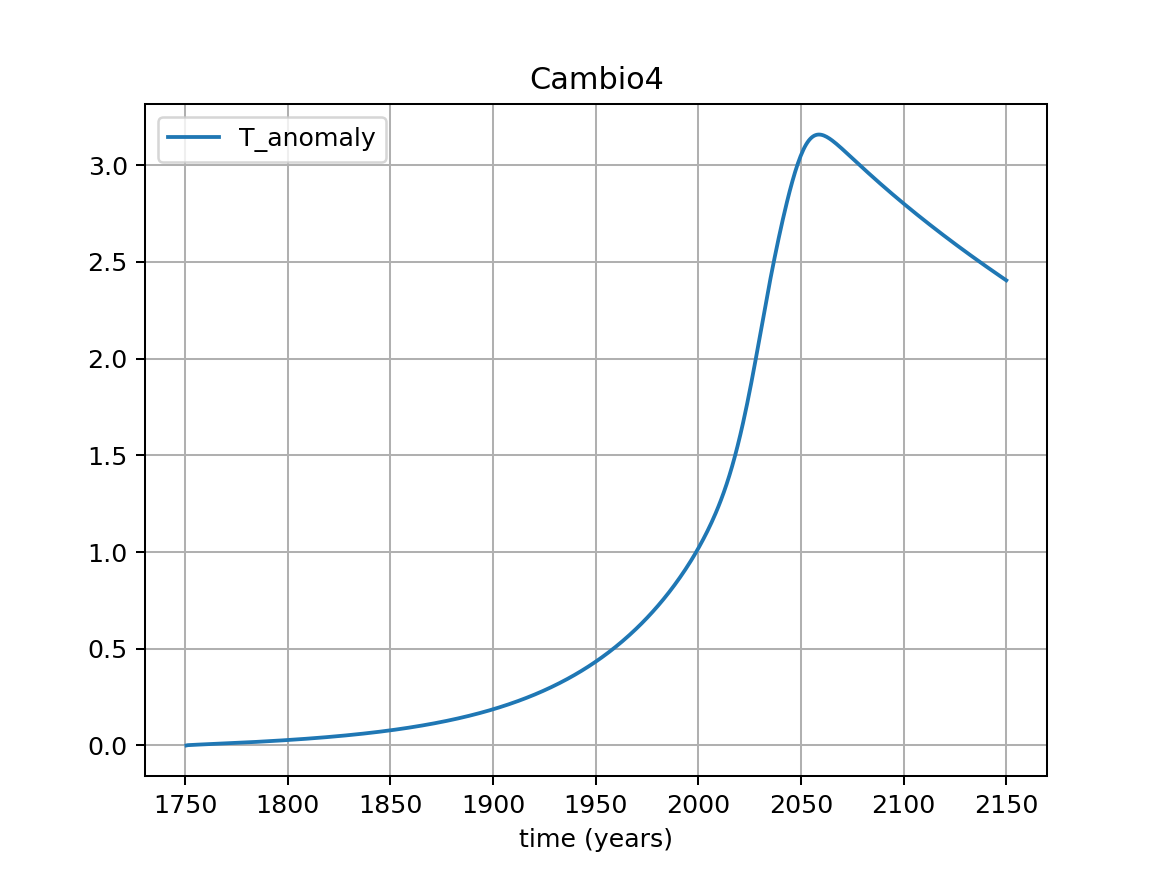

Max of Cambio4 (T_anomaly) =  3.158382881233997 at time  2058.514190317217
Min of Cambio4 (T_anomaly) =  0.0 at time  1750.6677796327212


<IPython.core.display.Javascript object>


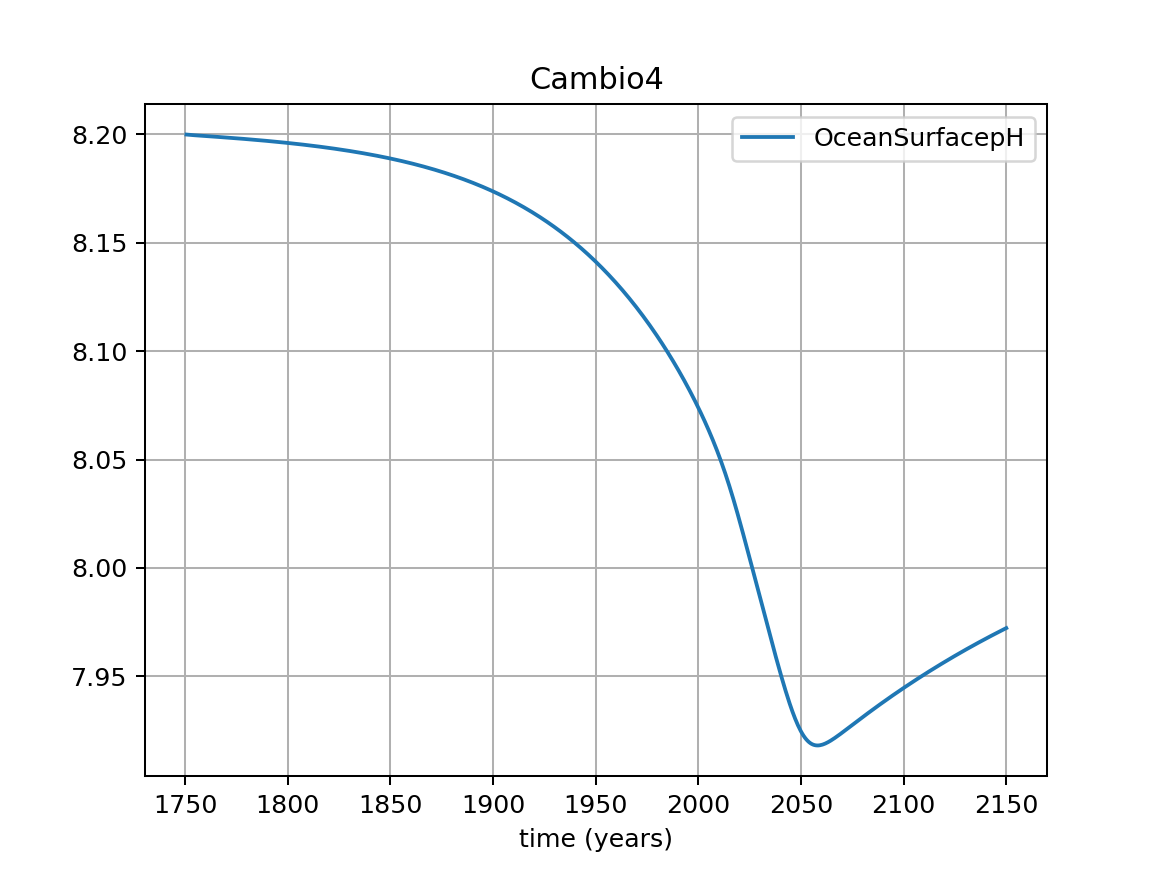

Max of Cambio4 (OceanSurfacepH) =  8.199933844249777 at time  1750.6677796327212
Min of Cambio4 (OceanSurfacepH) =  7.9181090396179545 at time  2057.846410684496


<IPython.core.display.Javascript object>


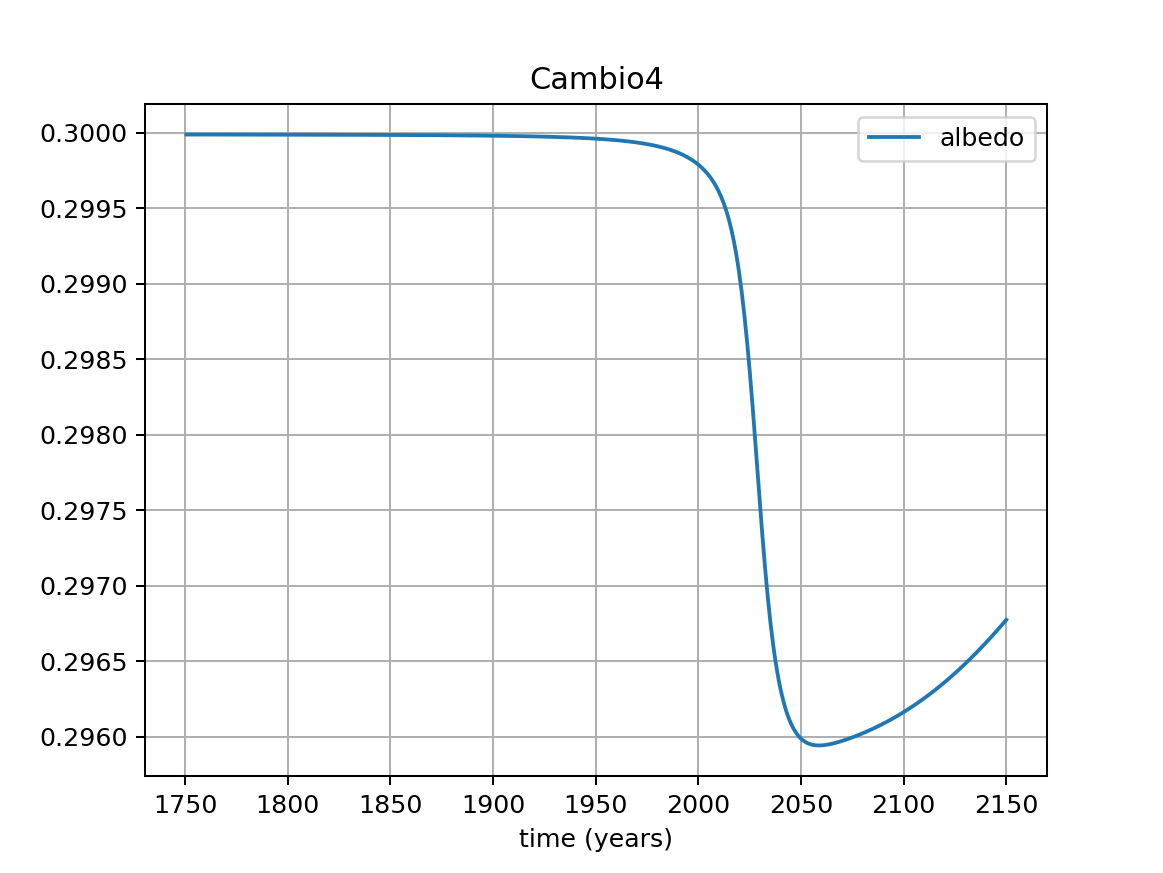

Max of Cambio4 (albedo) =  0.29998965731558996 at time  1750.6677796327212
Min of Cambio4 (albedo) =  0.29594272269685756 at time  2058.514190317217


In [21]:
ClimateState_Cambio_list = CL.run_Cambio(CL.PropagateClimateState_Cambio4, ClimateParams_test, epstime, eps)
items_to_plot = [['C_atm','C_ocean'],['F_ocean_net','F_land_net','F_ha'],'T_anomaly','OceanSurfacepH', 'albedo']
CL.Climatestate_list_plots(ClimateState_Cambio_list,items_to_plot,'Cambio4')

### Looking at the excess carbon in the atmosphere and oceans in a log space

<IPython.core.display.Javascript object>


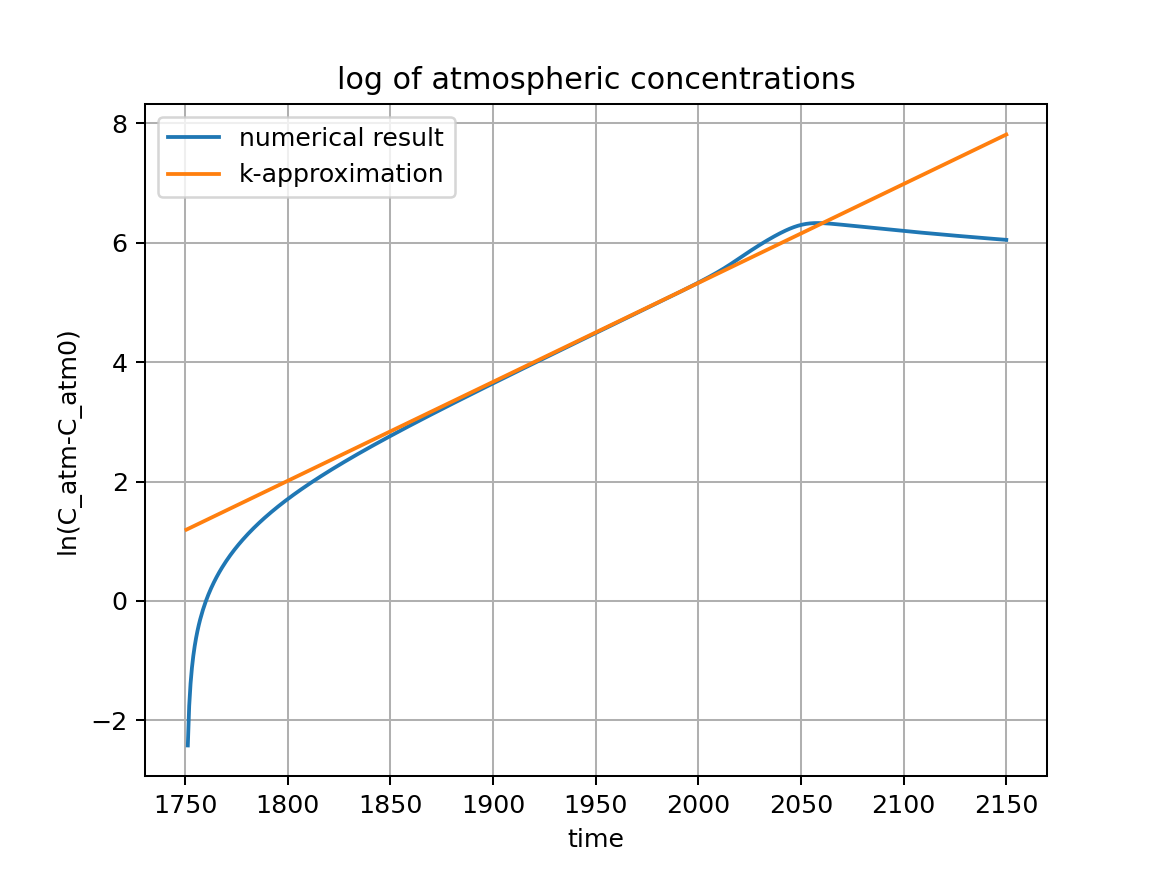

300


<IPython.core.display.Javascript object>


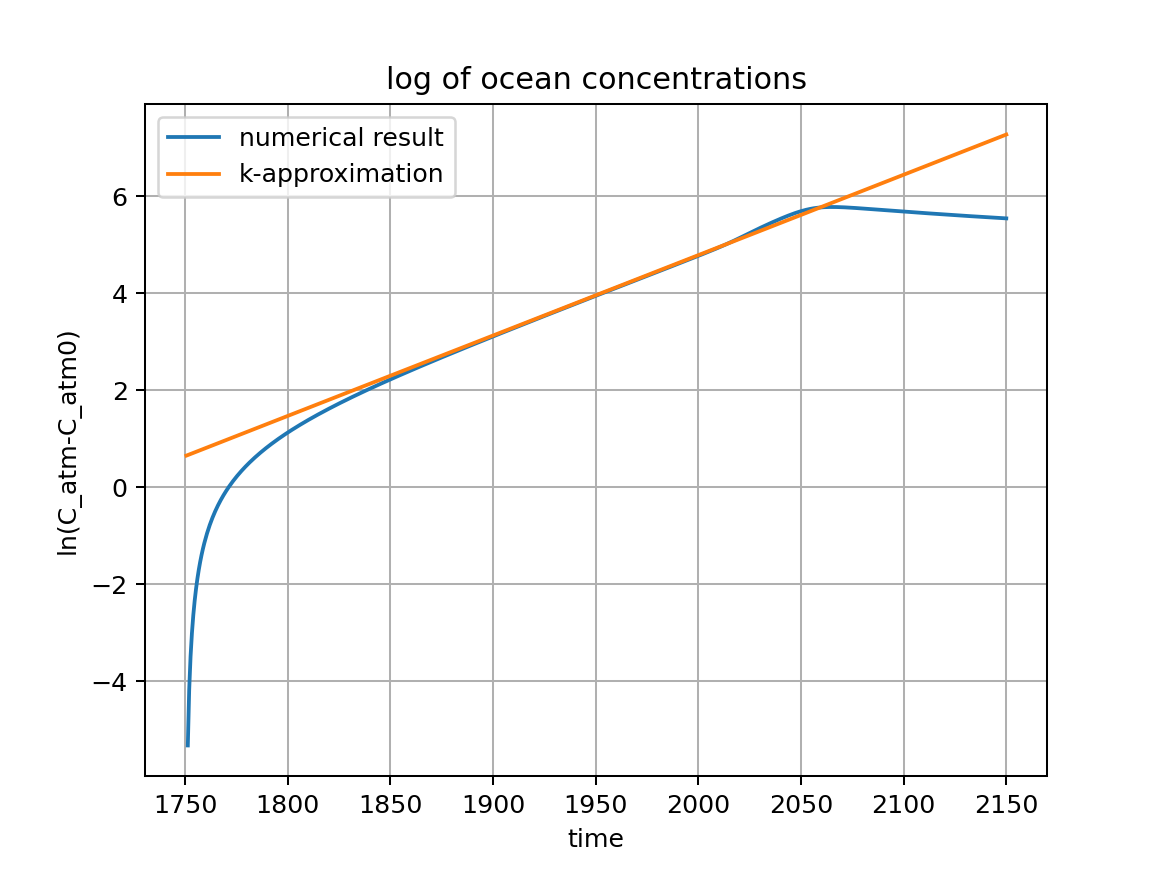

300


In [22]:
# Looking at the excess carbon in the atmosphere
time_array = CL.CollectClimateTimeSeries(ClimateState_Cambio_list,'time')
C_atm_array = CL.CollectClimateTimeSeries(ClimateState_Cambio_list,'C_atm')
y_numerical = np.log(C_atm_array[1:]-C_atm_array[0])
plt.figure()
plt.title('log of atmospheric concentrations')
plt.plot(time_array[1:],y_numerical,label='numerical result')
plt.grid('True')
plt.xlabel('time')
plt.ylabel('ln(C_atm-C_atm0)')
imid = round(len(time_array)/2); print(imid)
y_usingk = y_numerical[imid] + k*(time_array-time_array[imid])
plt.plot(time_array,y_usingk,label='k-approximation')
plt.legend()

# Looking at the excess carbon in the ocean
C_ocean_array = CL.CollectClimateTimeSeries(ClimateState_Cambio_list,'C_ocean')
y_numerical = np.log(C_ocean_array[1:]-C_ocean_array[0])
plt.figure()
plt.title('log of ocean concentrations')
plt.plot(time_array[1:],y_numerical,label='numerical result')
plt.grid('True')
plt.xlabel('time')
plt.ylabel('ln(C_atm-C_atm0)')
imid = round(len(time_array)/2); print(imid)
y_usingk = y_numerical[imid] + k*(time_array-time_array[imid])
plt.plot(time_array,y_usingk,label='k-approximation')
plt.legend()

### Looking at the ratio of net ocean sequestration to net land sequestration

r (predicted) = 0.6666666666666666
r (observed) = 0.601398685269946


<IPython.core.display.Javascript object>


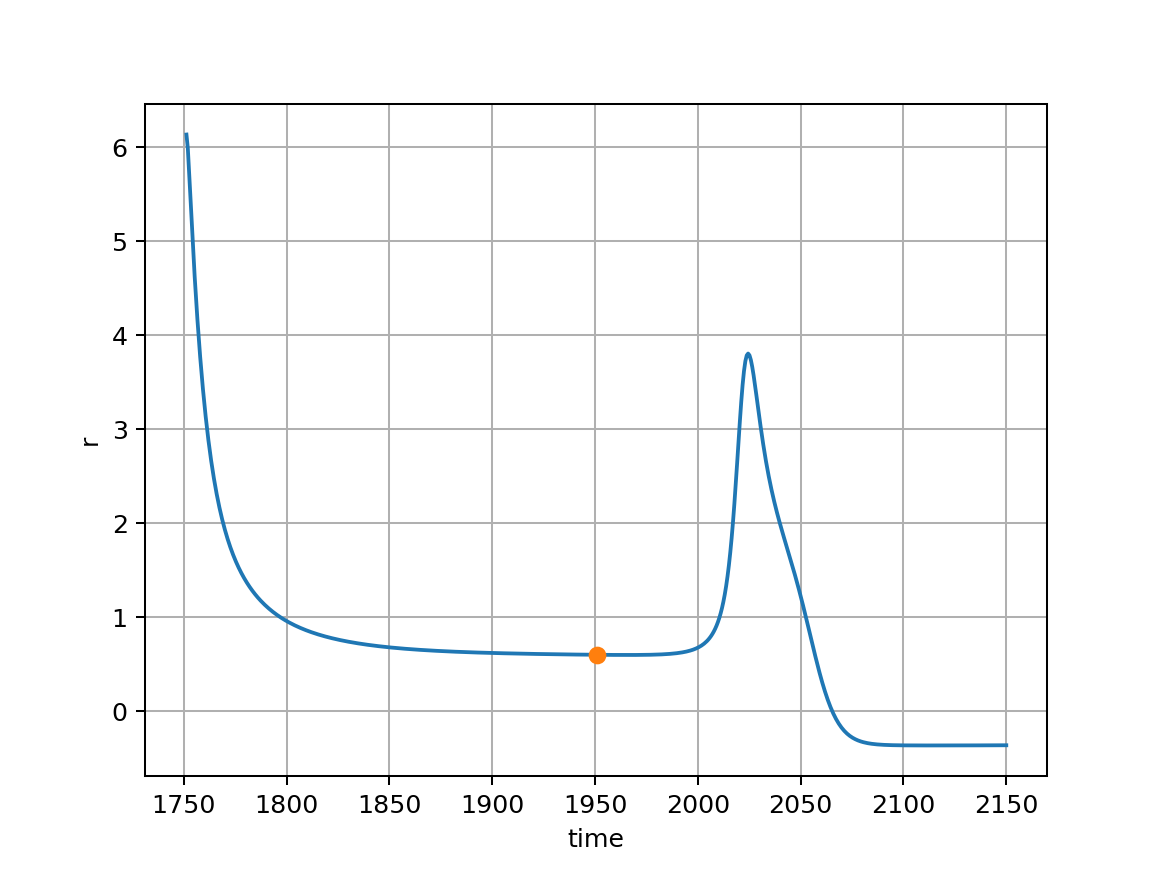

Text(0, 0.5, 'r')

In [23]:
# Calculating the ratio "r"
F_land_net = CL.CollectClimateTimeSeries(ClimateState_Cambio_list,'F_land_net')
F_ocean_net = CL.CollectClimateTimeSeries(ClimateState_Cambio_list,'F_ocean_net')
r_numerical = F_ocean_net / F_land_net
print('r (predicted) =', r)
print('r (observed) =', r_numerical[imid])

plt.figure()
plt.plot(time_array[1:],r_numerical[1:])
plt.plot(time_array[imid],r_numerical[imid],'o')
plt.grid('True')
plt.xlabel('time')
plt.ylabel('r')


### Analysis of the ocean carbon reservoir
Is 443 GtC pre-industrial, or 575 GtC in year 2003, reasonable?

The NASA figure indicates the region of "air-sea gas exchange" contains $1000 \ GtC$. Carroll et al, 2022 Fig. 9, find a total DIC of 880 GtC in the top 100 meters alone.

By contrast, the total amount of DIC is much bigger, more like 37,000 GtC (according to NASA and other sources). Of that DIC, at a pH of 8, only about 2% of DIC is in the form $CO_2(aq)$, as shown by the table in https://www.aqion.de/site/153. So, our figure of 575 in year 2003 GtC is fairly close to the $CO_2(aq)$ portion to a depth of 1500 m (or so), 2% of 37,000, or 750 GtC. Hence, our kinetic scheme would be more accurately written

$$
F_{oa} = k_{oa}[C_{ocean, CO_2(aq)}] = k_{oa}f_{CO_2}[C_{ocean, DIC}] = k_{oa}'[C_{ocean, DIC}]
$$

where we're defining $f_{CO_2} \equiv [C_{ocean, CO_2(aq)}]/[C_{ocean}] \approx 2\%$.

An approximation would be to claim that that equilibrium is so fast, and the DIC amount is so big, that $[C_{ocean, CO_2(aq)}] \approx constant$. However, that doesn't work -- there has to be depletion of $[C_{ocean, DIC}]$. 

### Getting $\Delta z$, the depth of the mixed layer
The idea here is to calculate $\Delta z$, the geometric thickness of the "mixed layer" of the ocean relevant to ocean/atmosphere exchange of $CO_2$. To do that, we begin with Henry's law, which says 

$$
P_{atm} y_{CO_2}=Hx_{CO_2}
$$

where $y_{CO_2}$ is the mole fraction of $CO_2$ in the air, $x_{CO_2}$ is the mole fraction of $CO_2$ in water, and $H$ is Henry's constant for $CO_2$ in aqueous solution. We should note the caveat that it's not clear how the aqueous chemistry of dissolved $CO_2$ figures in here, but for now we'll just say the derivative species -- carbonate and bicarbonate -- are not included in $x_{CO_2}$. 

With that caveat, the mole fraction of $CO_2$ in water is given by

$$
x_{CO_2} = Py_{CO_2}/H
$$

Next, we assemble the following additional equations (all approximations). First, the area of the oceans (assuming $2/3$ coverage) is given by 

$$
A_{oceans} = 4 \pi r^2 \times {2 \over 3} \ \ \ (1)
$$

We can express the mass of water in the oceans within our ocean's $\Delta z$ as

$$
m_{H_2O} = A_{oceans} \Delta z \times \rho_{H_2O}
$$

The moles of water within that layer is 

$$
n_{H_2O} = {m_{H_2O} \over M_{H_2O}}
$$

where $M_{H_2O}$ is the molar mass of water. Assuming seawater is sufficiently dilute, the mole fraction of $CO_2$ in water can be approximated as  

$$
x_{CO_2} = {n_{CO_2} \over n_{H_2O}}
$$

where the moles of $CO_2$ can be related to the mass of $CO_2$ using $M_{CO_2}$, the molar mass of $CO_2$, according to  

$$
n_{CO_2} = {m_{CO_2} \over M_{CO_2}}
$$

Solving these equations for $\Delta z$, we get

$$
\Delta z = {m_{CO_2} \over A_{oceans} \times \rho_{H_2O} \times x_{CO_2}} {M_{H_2O} \over M_{CO_2}}
$$

Values we can use are the molar masses
- $M_{CO_2}=44 \ g/mol$
- $M_{H_2O}=18 \ g/mol$
- $y_{CO_2}=290 \ ppm = 290 \times 10^{-6}$ (pre-industrial value)
- $H = 1670 \ atm$ 

where the last value is obtained from https://www.vedantu.com/question-answer/henrys-law-constant-for-co2-in-water-is-167times-class-12-chemistry-cbse-5f5669d16791b91adfa23385. Also: https://henrys-law.org/henry/casrn/124-38-9.

Temperature dependence reference for H: https://henrys-law.org/henry/casrn/124-38-9.

In [24]:
P_atm = AssignQuantity(1,'atm')
Henry = AssignQuantity(1670,'atm')
y = AssignQuantity(290e-6,'dimensionless')
x_CO2 = y*P_atm/Henry; print('x_CO2 =',x_CO2)
radius_of_Earth = AssignQuantity(6400,'km')
Area_of_oceans = 4*np.pi*radius_of_Earth**2 * (2/3)
density_of_seawater = AssignQuantity(1,'g/cm^3')
M_H2O = AssignQuantity(18,'g/mol')
M_CO2 = AssignQuantity(44,'g/mol')
m_CO2 = AssignQuantity(C_ocean_preind*1e15,'gram')
delta_z = m_CO2*M_H2O/M_CO2/(Area_of_oceans*density_of_seawater*x_CO2)
delta_z.ito('km')
print('Geometrical thickness of the aqueous CO2 reservoir =', delta_z)

delta_z_CO2aq = delta_z
print('Geometrical thickness of the aqueous CO2 reservoir =', delta_z_CO2aq)

delta_z_DIC = delta_z * 0.02
delta_z_DIC.ito('m')
print('Geometrical thickness of the DIC reservoir =', delta_z_DIC)

# The lines below are double-checking the analysis above (especially values of Henry's constant, which
# is published in many different units)

# See also https://webbook.nist.gov/cgi/cbook.cgi?ID=C124389&Mask=10

K_H = AssignQuantity(0.032,'mol/L/atm'); print(K_H)
P_CO2 = y*AssignQuantity(1,'atm'); print(P_CO2)
C_CO2_aq = K_H*P_CO2; print(C_CO2_aq)
x_CO2 = C_CO2_aq/AssignQuantity(55.5,'mol/L');print(x_CO2)

K_H = AssignQuantity(0.034,'mol/L/bar')
K_H.ito('mol/L/atm'); print(K_H)

x_CO2 = 1.7365269461077844e-07 dimensionless
Geometrical thickness of the aqueous CO2 reservoir = 3.039377095510883 kilometer
Geometrical thickness of the aqueous CO2 reservoir = 3.039377095510883 kilometer
Geometrical thickness of the DIC reservoir = 60.78754191021766 meter
0.032 mole / liter / standard_atmosphere
0.00029 standard_atmosphere
9.280000000000001e-06 mole / liter
1.6720720720720721e-07 dimensionless
0.0344505 mole / liter / standard_atmosphere


### Messing around with conversions of carbon amounts
See (https://acp.copernicus.org/articles/13/2793/2013/acp-13-2793-2013-supplement.pdf)

In [25]:
GtC_over_ppm = 2.123
print('Pre-industrial atmospheric carbon in GtC:')
print(290*GtC_over_ppm)

GtCO2_over_GtC = 44/12
GtC_over_GtCO2 = 1/GtCO2_over_GtC
print(GtC_over_ppm, GtCO2_over_GtC, GtC_over_GtCO2)

C_atm_2024_ppm = 424
C_atm_2024_GtC = C_atm_2024_ppm*GtC_over_ppm; print('Current mass of C =', C_atm_2024_GtC, 'GtC')
C_atm_2024_GtCO2 = C_atm_2024_GtC*GtCO2_over_GtC; print('Current mass of CO2 =', C_atm_2024_GtCO2, 'GtCO2')

# The NASA figure says 800 GtC
C_atm_NASA_GtC = 800
C_atm_NASA_ppm = C_atm_NASA_GtC/GtC_over_ppm
print('NASA figure ... ', C_atm_NASA_ppm, C_atm_NASA_GtC)

# Based on https://gml.noaa.gov/ccgg/trends/graph.html (January values at Mauna Loa)
print('Start of the year')
C_atm_2005_ppm = 379.10; print(C_atm_2005_ppm, C_atm_2005_ppm*GtC_over_ppm)
C_atm_2004_ppm = 377.19; print(C_atm_2004_ppm, C_atm_2004_ppm*GtC_over_ppm)
C_atm_2003_ppm = 374.90; print(C_atm_2003_ppm, C_atm_2003_ppm*GtC_over_ppm)

Pre-industrial atmospheric carbon in GtC:
615.6700000000001
2.123 3.6666666666666665 0.27272727272727276
Current mass of C = 900.152 GtC
Current mass of CO2 = 3300.557333333333 GtCO2
NASA figure ...  376.8252472915685 800
Start of the year
379.1 804.8293000000001
377.19 800.7743700000001
374.9 795.9127000000001


### Data from from Dorgeist et al, 2024
Using this figure from Dorgeist et al, 2024, *A consistent budgeting of terrestrial
carbon fluxes*:
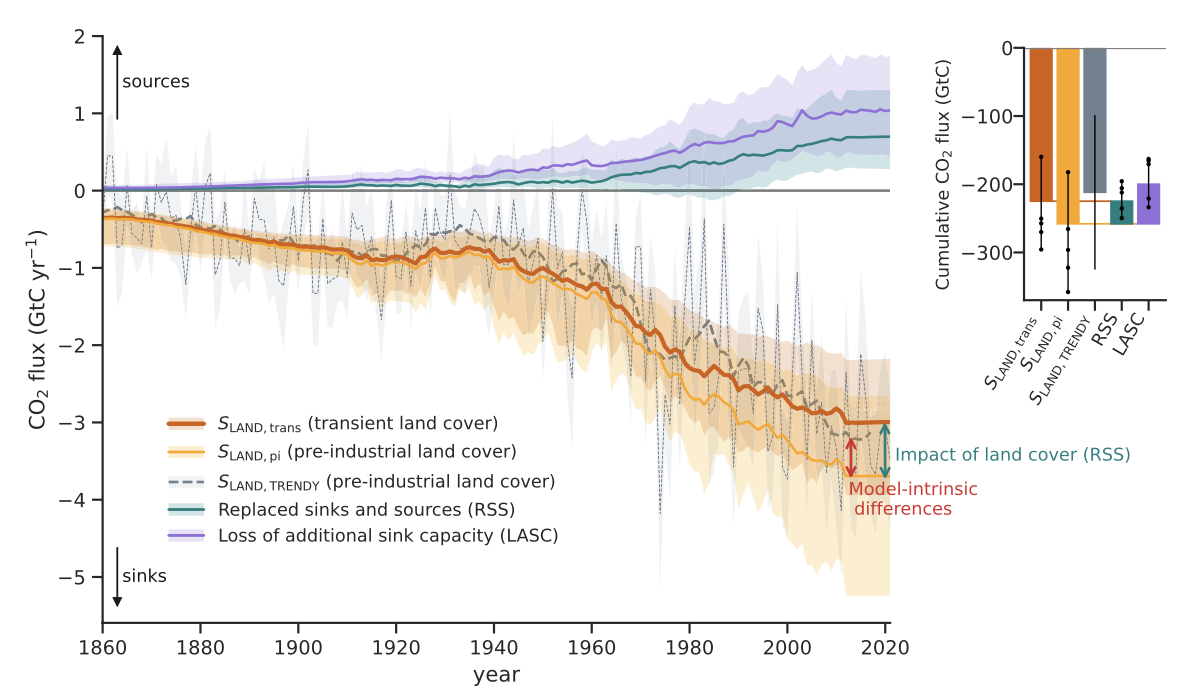

### World population
These data come from https://www.worldometers.info/world-population/world-population-by-year/. It's not very exponential, but even so, the best fit yields a growth rate from 1950 to present of about $1.64\% yr^{-1}$. By comparison, emissions have been about $1.65\% yr^{-1}$.

Qualitatively, after 1950 human emissions have tracked population very closely. 

k based on our world in data = 0.010718872584615437
intercept based on our world in data = 0.010718872584615437


<IPython.core.display.Javascript object>


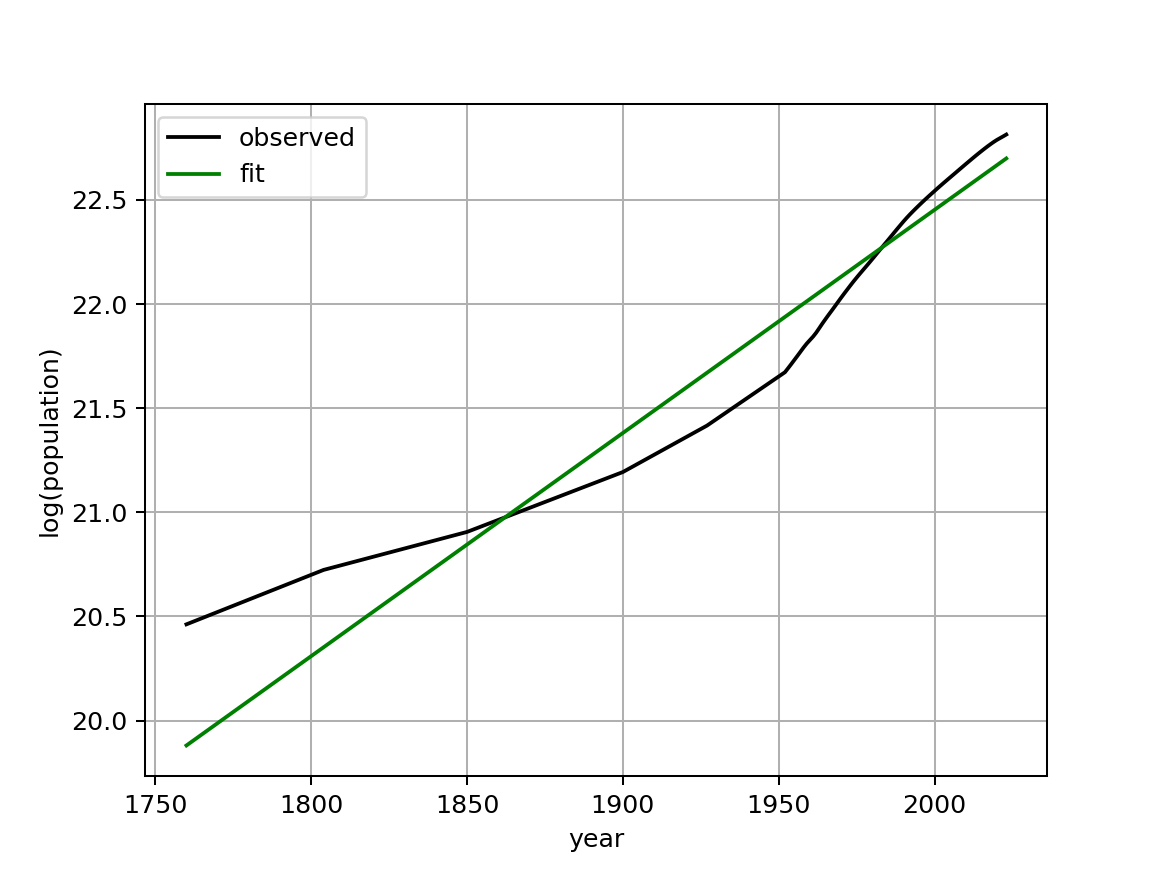

k based on our world in data = 0.016412456487933214
intercept based on our world in data = 0.016412456487933214


<IPython.core.display.Javascript object>


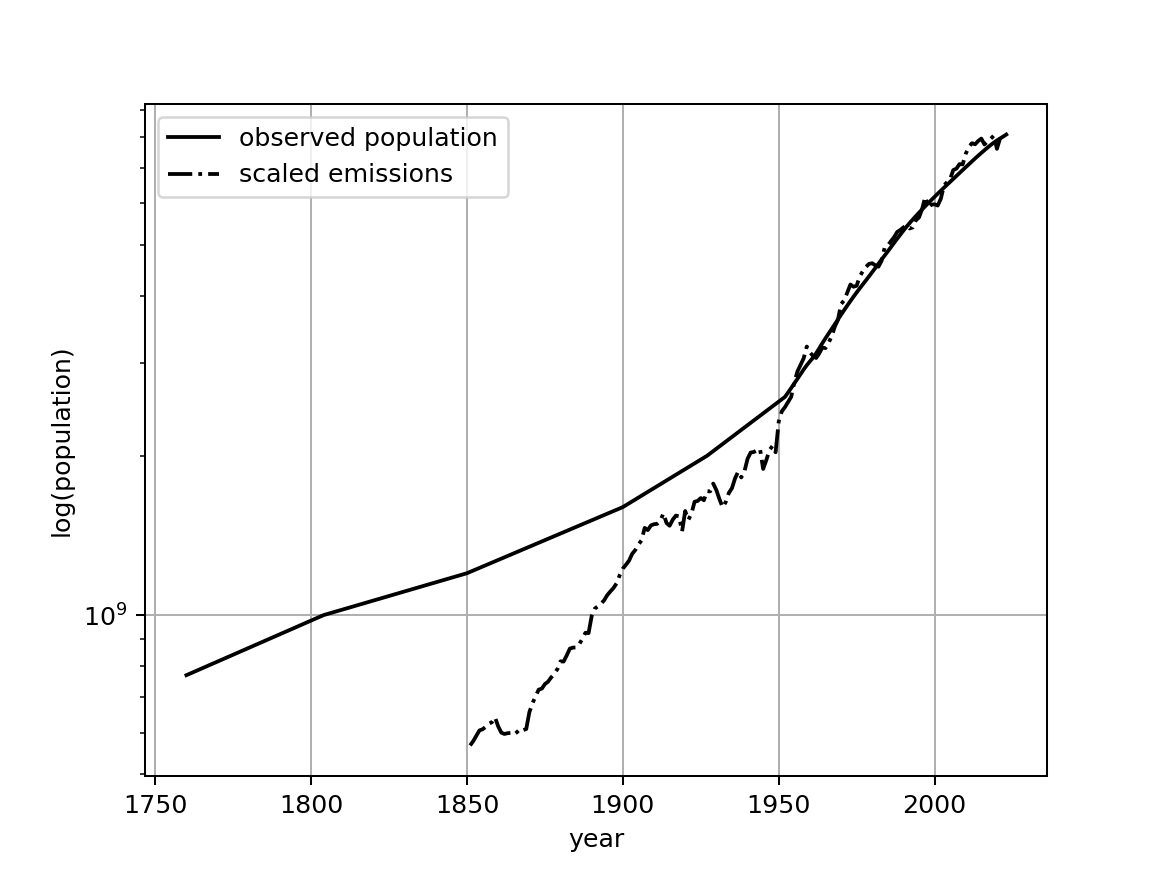

In [26]:
my_data = genfromtxt('World population.csv', delimiter=',')

# Use all the data
wp_time = my_data[1:,0]
wp_population = my_data[1:,1]

# Fitting
logwp_population = np.log(wp_population)
popt, pcov = curve_fit(linfun, wp_time, logwp_population)
k_wp_population = popt[0]
intercept_logwp_population = popt[1]
print('k based on our world in data =', k_wp_population)
print('intercept based on our world in data =', k_wp_population)
logwp_population_bestfit = intercept_logwp_population + k_wp_population*wp_time

plt.figure()
plt.plot(wp_time,logwp_population,'k',label='observed')
plt.plot(wp_time,logwp_population_bestfit,'g',label='fit')
plt.grid(True)
plt.xlabel('year')
plt.ylabel('log(population)')
plt.legend()

# Use data since 1950
istop = 5
wp_time_short = my_data[1:-istop,0]
wp_population_short = my_data[1:-istop,1]

# Fitting
logwp_population_short = np.log(wp_population_short)
popt, pcov = curve_fit(linfun, wp_time_short, logwp_population_short)
k_wp_population_short = popt[0]
intercept_logwp_population_short = popt[1]
print('k based on our world in data =', k_wp_population_short)
print('intercept based on our world in data =', k_wp_population_short)
logwp_population_bestfit = intercept_logwp_population_short + k_wp_population*wp_time_short

plt.figure()
scale = 0.71
plt.semilogy(wp_time,wp_population,'k', label='observed population')
plt.semilogy(time,eps_ourworldindata*scale,'k-.',label='scaled emissions')
plt.grid(True)
plt.xlabel('year')
plt.ylabel('log(population)')
plt.legend()